# Shill Bidding Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
from scipy import stats
#from scipy.special import boxcox1p
#from scipy.stats import boxcox_normmax
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier
from sklearn.svm import SVC

#Common Model Helpers
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from matplotlib.colors import ListedColormap

from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import optuna

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

seed = 42

In [2]:
shill = pd.read_csv('Shill_Bidding_Dataset.csv')
shill.head()

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.0,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.0,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.0,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.0,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.0,0.000000,0.001242,0.500000,7,0


In [3]:
fraud_cases = shill[shill["Class"] == 1]
valid_cases = shill[shill["Class"] == 0]

Outlier_fraction=len(fraud_cases)/float(len(valid_cases))
print(Outlier_fraction)
print("fraud cases {}".format(len(fraud_cases)))
print("Valid cases {}".format(len(valid_cases)))

0.11955366631243358
fraud cases 675
Valid cases 5646


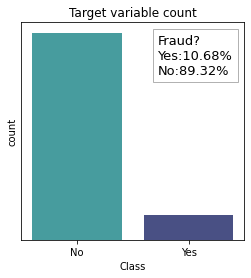

In [4]:
perc_1 = len(shill[shill['Class']==1])/len(shill)
perc_0 = len(shill[shill['Class']==0])/len(shill)

labels=['No','Yes']

plt.figure(figsize=(4,4))
ax = sns.countplot(x='Class', data=shill, palette='mako_r')
#ax.bar_label(ax.containers[0])
plt.title('Target variable count')
plt.yticks([])
plt.figtext(.6, .7, "Fraud?\nYes:{:.2f}%\nNo:{:.2f}%".format(perc_1*100,perc_0*100), bbox ={'facecolor':'white', 
                   'alpha':0.3, 'pad':5}, fontsize=13)
plt.xticks(shill['Class'].value_counts().index, labels)
plt.show()

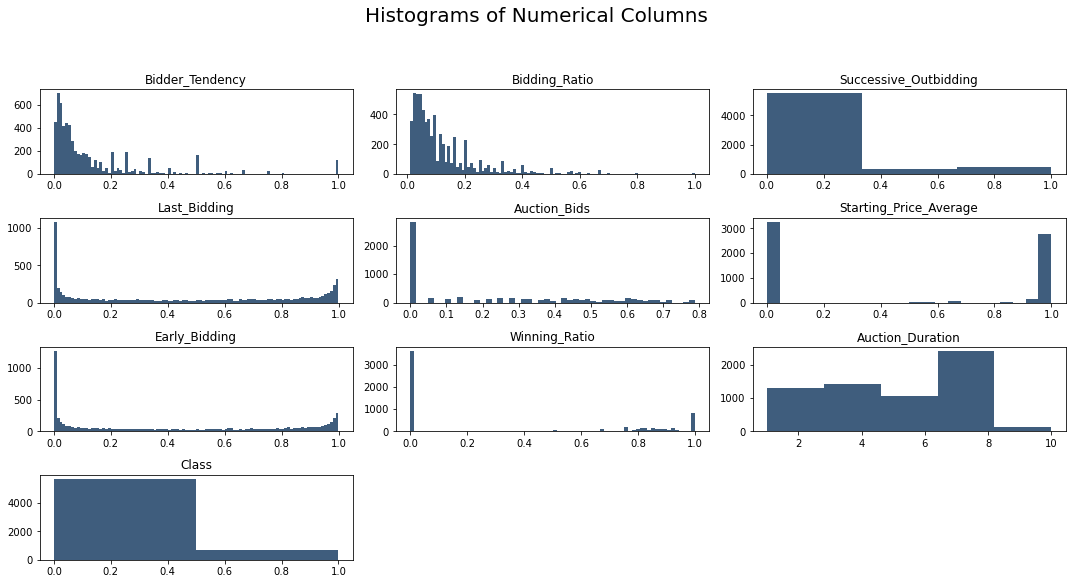

In [5]:
shill3 = shill.copy().drop(columns = ['Auction_ID','Bidder_ID','Record_ID']) 

fig = plt.figure(figsize=(15,12))

plt.suptitle('Histograms of Numerical Columns', fontsize = 20)
#Since we want to plot every feature in one single plot, we re going to iterate every feature

for i in range(shill3.shape[1]):
    #This will iterate every feature.Shape gives the dimensions of the dataframe and he first item gives the number of columns
    #and since python does not include all the columns we are adding 1 to it. 
    plt.subplot(6,3,i+1)
    #Here in subplot, we are going to tell python number of images in the plot.'i' is given to tell what we are 
    #working on the moment
    f = plt.gca()
    #gca() command cleans up everything
    f.set_title(shill3.columns.values[i])
    #It will title each feature
    
    vals = np.size(shill3.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
    #It will tell python how many bins will be in each feature. [:, i-1 ] will query the entire column
    
    plt.hist(shill3.iloc[:, i], bins = vals, color= '#3F5D7D')
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

**HISTOGRAM**

BIDDER TENDENCY: From the histogram we see that most of the people have the value of 0 - 0.2. Between 0.2 - 0.4, we see the next cluster of Bids.

Bidding Ratio : The histogram implies that the majority of people are in the Bidding Ratio of 0 - 0.2 which means in most cases, there is no bidding ratio.

Successive Outbidding: There is a high percentage of people in the 0 category and very less people in the in 1 category which implies that most records show that they do not indulge in successive outbidding.

Last Bidding: A Shill Bidder becomes inactive at the last stage. There is not an evidence of Last Bidding but in the end, the data shows a spike in the number of people in last bidding.

Auction Duration : The data shows that the auction duration is mainly between 1 - 6 for most number of biddings and between 6-8, the number of bidding is the highest.

Class: The histogram suggest in most of the bidding cases(6000), the data is 0 which implies the shill bidding did not take place while the answer is 1 for around less than 1000 cases.

<AxesSubplot:>

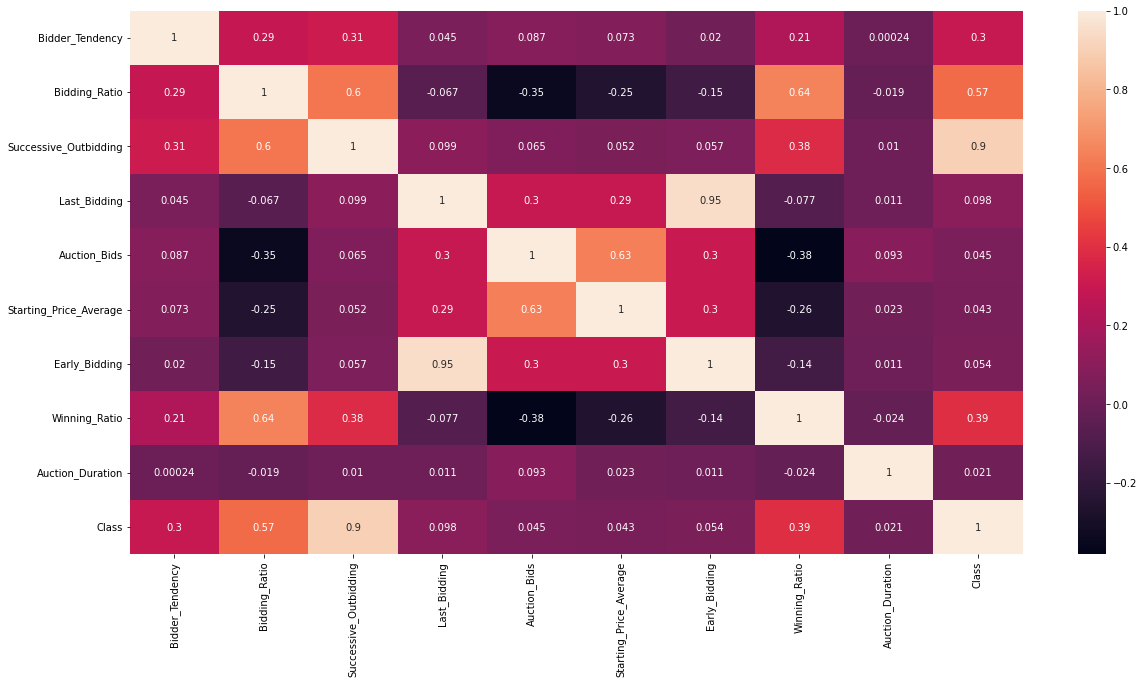

In [6]:
plt.figure(figsize = (20,10))
sns.heatmap(shill3.corr(), annot = True)

<AxesSubplot:title={'center':'Correlation with the response Variable'}>

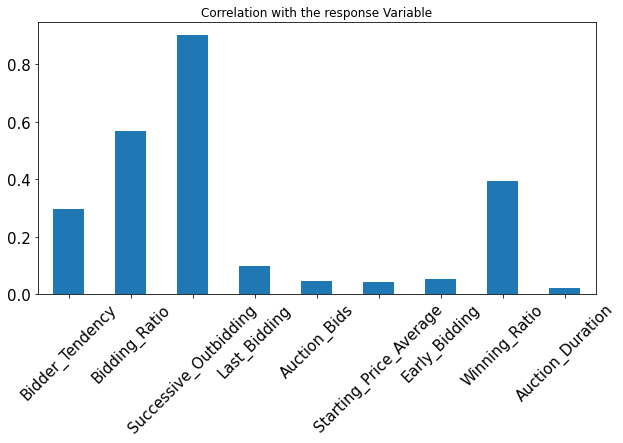

In [7]:
shill2 = shill.copy().drop(columns = ['Class','Auction_ID','Bidder_ID','Record_ID'])

shill2.corrwith(shill.Class).plot.bar(figsize = (10,5), title = 'Correlation with the response Variable', fontsize = 15, rot= 45)

**Cor-relation Plot**
Successive Outbidding: A shill bidder successively outbids himself even though he is the current winner to increase the price gradually with small consecutive increments.

The co-relation plot for Successive Outbidding and response variable is highest. It suggests that if there is successive outbidding, then the co-relation of outbidding is the highest.

Bidding Tendency, Bidding Ratio, Winning Ratio also have high correlation which show that if their value is high, so is the probability of the Bidder indulging in Shill Bidding.

The correlation of Last Bidding, Auction Bids, Starting Price Average, Early Bidding and Auction Duration has a very low corelation with the response variable. It suggests that these variables have very less infleunce on the response variable.

Positive Correlation:

Bidder Tendency and Bidding Ratio, Successive Outbidding, Winning Ratio have high correlation.

Successive Outbidding and Winning ratio have high correlation.

Last Bidding and Starting Price Average, Early Bidding, and Auction Bids have positive correlation.

Negative Correlation:

Bidding Ratio and Auction Bids, Starting Price Average, Early Bidding have negative correlation

Auction Bids and Winning Ratio have negative corelation.

Starting Price Average and Winning Ratio have negative correlation

**Data Split**

In [255]:
X = shill.drop(columns=['Class', 'Record_ID', 'Auction_ID', 'Bidder_ID', 'Auction_Duration'])
y = shill.Class
X

,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio
0,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667
1,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444
2,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000
3,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000
4,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000
...,...,...,...,...,...,...,...,...
6316,0.333333,0.160000,1.0,0.738557,0.280000,0.993593,0.686358,0.888889
6317,0.030612,0.130435,0.0,0.005754,0.217391,0.993593,0.000010,0.878788
6318,0.055556,0.043478,0.0,0.015663,0.217391,0.993593,0.015663,0.000000
6319,0.076923,0.086957,0.0,0.068694,0.217391,0.993593,0.000415,0.000000


In [256]:
y.value_counts()

0    5646
1     675
Name: Class, dtype: int64

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)

print(f"Training set: {X_train.shape[0]}")
print(f"Validation set: {X_val.shape[0]}")
print(f"Test set: {X_test.shape[0]}")

Training set: 4044
Validation set: 1012
Test set: 1265


In [258]:
y_train.value_counts()

0    3612
1     432
Name: Class, dtype: int64

In [259]:
shill[shill.duplicated()].shape

(0, 13)

So, there is no duplicate in this dataset

In [260]:
shill.columns

Index(['Record_ID', 'Auction_ID', 'Bidder_ID', 'Bidder_Tendency',
       'Bidding_Ratio', 'Successive_Outbidding', 'Last_Bidding',
       'Auction_Bids', 'Starting_Price_Average', 'Early_Bidding',
       'Winning_Ratio', 'Auction_Duration', 'Class'],
      dtype='object')

In [261]:
shill.isna().any()

Record_ID                 False
Auction_ID                False
Bidder_ID                 False
Bidder_Tendency           False
Bidding_Ratio             False
Successive_Outbidding     False
Last_Bidding              False
Auction_Bids              False
Starting_Price_Average    False
Early_Bidding             False
Winning_Ratio             False
Auction_Duration          False
Class                     False
dtype: bool

# Applying PCA

In [262]:
X_scaled = scaler.fit_transform(X)

In [263]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_scaled);

In [264]:
cum_sum = np.cumsum(pca.explained_variance_ratio_)*100
comp= [n for n in range(len(cum_sum))]

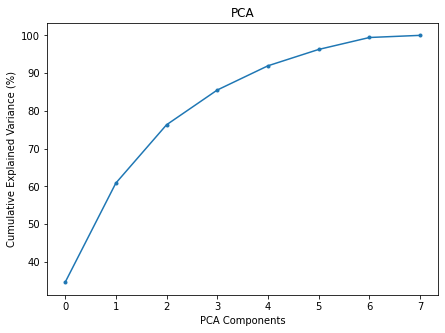

In [265]:
plt.figure(figsize=(7,5))
plt.plot(comp, cum_sum, marker='.')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA')
plt.show()

# Class balance by Undersampling

When undersampling, we aim to remove a number of the rows of the majority class (rows where class=0) in order to match the number of rows of the minority class (rows where class=1).

In [266]:
y_train.value_counts()

0    3612
1     432
Name: Class, dtype: int64

In [267]:
rus = RandomUnderSampler(random_state=seed)

In [268]:
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

In [269]:
y_train_us.value_counts()

0    432
1    432
Name: Class, dtype: int64

In [270]:
X_train_us, X_val_us, y_train_us, y_val_us = train_test_split(X_train_us, y_train_us, test_size=0.2, random_state = seed)

# Class balance by oversampling with SMOTE

Now, oversampling will be performed on the training data.

In [271]:
y_train.value_counts()

0    3612
1     432
Name: Class, dtype: int64

This means that we will add 3612 - 432 = 3180 rows with 'Class' = 1, which is indeed a large number of duplicates that will be added.

In [272]:
smote = SMOTE(random_state=seed)

X_train_os, y_train_os = smote.fit_resample(X_train, y_train)

y_train_os.value_counts()

0    3612
1    3612
Name: Class, dtype: int64

The training data is now balanced.

In [273]:
X_train_os, X_val_os, y_train_os, y_val_os = train_test_split(X_train_os, y_train_os, stratify=y_train_os, test_size=0.2, random_state = seed)

# Hybrid Sampling Method

A combination of under- and oversampling method using pipeline

In [274]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
from matplotlib import pyplot

In [275]:
# define pipeline
over = SMOTE(sampling_strategy = "not minority")
under = RandomUnderSampler(sampling_strategy = "majority")
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_h, y_h = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y_h)
print(counter)

Counter({0: 675, 1: 675})


In [276]:
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_h, y_h, test_size=0.2, stratify = y_h, random_state=seed)

scaler = StandardScaler()

X_train_h = scaler.fit_transform(X_train_h)
X_test_h = scaler.transform(X_test_h)

X_train_h, X_val_h, y_train_h, y_val_h = train_test_split(X_train_h, y_train_h, test_size=0.2, stratify=y_train_h, random_state=seed)

print(f"Training set: {X_train_h.shape[0]}")
print(f"Validation set: {X_val_h.shape[0]}")
print(f"Test set: {X_test_h.shape[0]}")

Training set: 864
Validation set: 216
Test set: 270


# Logistic Regression

## Imbalanced Dataset

In [277]:
LogReg = LogisticRegression()
LogReg.fit(X_train,y_train)

print('Accuracy on whole data : ' + str(LogReg.score(X, y)))
print('Accuracy on training data : ' + str(LogReg.score(X_train, y_train)))
print('Accuracy on testing data : ' + str(LogReg.score(X_test, y_test)))

Accuracy on whole data : 0.8932130991931656
Accuracy on training data : 0.9745301681503462
Accuracy on testing data : 0.9770750988142293


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [278]:
def evaluate(y, y_hat):
        y = (y == 1)
        
        y_hat = (y_hat == 1)
        
        accuracy = (y == y_hat).sum() / y.size
        precision = (y & y_hat).sum() / y_hat.sum()
        recall = (y & y_hat).sum() / y.sum()
        
        return accuracy, recall, precision

In [279]:
y_hat = LogReg.predict(X_train)
log_train_acc, log_train_rec, log_train_pres = evaluate(y_train, y_hat)
print('Logistic regression accuracy on train data  :  ' + str(log_train_acc))
print('Logistic regression recall on train data  :  ' + str(log_train_rec))
print('Logistic regression precision on train data  :  ' + str(log_train_pres))

Logistic regression accuracy on train data  :  0.9745301681503462
Logistic regression recall on train data  :  0.8981481481481481
Logistic regression precision on train data  :  0.8680089485458613


In [280]:
y_p = LogReg.predict(X)
log_train_acc, log_train_rec, log_train_pres = evaluate(y, y_p)
print('Logistic regression accuracy on data  :  ' + str(log_train_acc))
print('Logistic regression recall on data  :  ' + str(log_train_rec))
print('Logistic regression precision on data  :  ' + str(log_train_pres))

Logistic regression accuracy on data  :  0.8932130991931656
Logistic regression recall on data  :  0.0
Logistic regression precision on data  :  nan


C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\USER\AppData\Local\Temp/ipykernel_15400/4155333726.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  precision = (y & y_hat).sum() / y_hat.sum()


In [281]:
y_pred = LogReg.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.985878  0.988496  0.987185      1130
         Yes   0.901515  0.881481  0.891386       135

    accuracy                       0.977075      1265
   macro avg   0.943697  0.934989  0.939285      1265
weighted avg   0.976875  0.977075  0.976962      1265



In [95]:
# Grid search cross validation
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.linear_model import LogisticRegression

# hyperparameter tuning

logreg=LogisticRegression()
param_grid = {"C":np.logspace(-3,3,7),
              #"penalty":["l2"],
              "solver" : ['lbfgs', 'liblinear', 'sag', 'saga']
             }# l1 lasso l2 ridge


sh = HalvingGridSearchCV(logreg, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train, y_train)

# print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
# print("accuracy :",logreg_cv.best_score_)

sh.best_estimator_

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was re

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was re

LogisticRegression(solver='liblinear')

In [282]:
logreg=LogisticRegression(solver='liblinear').fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.986749  0.988496  0.987622      1130
         Yes   0.902256  0.888889  0.895522       135

    accuracy                       0.977866      1265
   macro avg   0.944502  0.938692  0.941572      1265
weighted avg   0.977732  0.977866  0.977793      1265



Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. But we achieved lower recall value for logistic regression model. Which means it has higher false negative.

By using this model, most of the users would see their *valid* activity labeled as *fraudolent*.

## Undersampling

In [283]:
logReg = LogisticRegression().fit(X_train_us, y_train_us)

y_pred = logReg.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.980531  0.990170      1130
         Yes   0.859873  1.000000  0.924658       135

    accuracy                       0.982609      1265
   macro avg   0.929936  0.990265  0.957414      1265
weighted avg   0.985046  0.982609  0.983178      1265



In [284]:
# hyperparameter tuning

logreg=LogisticRegression()
param_grid = {"C":np.logspace(-3,3,7),
              #"penalty":["l2"],
              "solver" : ['lbfgs', 'liblinear', 'sag', 'saga']
             }


sh = HalvingGridSearchCV(logreg, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_us, y_train_us)


sh.best_estimator_

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was re

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was re

LogisticRegression(C=0.1)

In [285]:
logreg=LogisticRegression(C=0.1).fit(X_train_us, y_train_us)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.980531  0.990170      1130
         Yes   0.859873  1.000000  0.924658       135

    accuracy                       0.982609      1265
   macro avg   0.929936  0.990265  0.957414      1265
weighted avg   0.985046  0.982609  0.983178      1265



## Oversampling

In [286]:
LogReg=LogisticRegression().fit(X_train_os, y_train_os)


y_pred = LogReg.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.980531  0.990170      1130
         Yes   0.859873  1.000000  0.924658       135

    accuracy                       0.982609      1265
   macro avg   0.929936  0.990265  0.957414      1265
weighted avg   0.985046  0.982609  0.983178      1265



In [287]:
# hyperparameter tuning

Logreg=LogisticRegression()
param_grid = {"C":np.logspace(-3,3,7),
              #"penalty":["l2"],
              "solver" : ['lbfgs', 'liblinear', 'sag', 'saga']
             }


sh = HalvingGridSearchCV(Logreg, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_os, y_train_os)


sh.best_estimator_

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was re

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was re

LogisticRegression(C=0.1, solver='liblinear')

In [289]:
Logreg=LogisticRegression(C=0.1, solver='liblinear').fit(X_train_os, y_train_os)

y_pred = Logreg.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.975221  0.987455      1130
         Yes   0.828221  1.000000  0.906040       135

    accuracy                       0.977866      1265
   macro avg   0.914110  0.987611  0.946748      1265
weighted avg   0.981668  0.977866  0.978767      1265



## Hybrid Sampling

In [290]:
#import warnings
#warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

Logreg = LogisticRegression().fit(X_train_h,y_train_h)

y_pred = Logreg.predict(X_test).round()
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.723009  0.839240      1130
         Yes   0.301339  1.000000  0.463122       135

    accuracy                       0.752569      1265
   macro avg   0.650670  0.861504  0.651181      1265
weighted avg   0.925439  0.752569  0.799101      1265



In [291]:
# hyperparameter tuning

Logreg=LogisticRegression()
param_grid = {"C":np.logspace(-3,3,7),
              #"penalty":["l2"],
              "solver" : ['lbfgs', 'liblinear', 'sag', 'saga']
             }


sh = HalvingGridSearchCV(Logreg, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_h, y_train_h)

sh.best_estimator_

C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was re

LogisticRegression(solver='liblinear')

In [292]:
Logreg=LogisticRegression(solver='liblinear').fit(X_train_h, y_train_h)

y_pred = Logreg.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.723009  0.839240      1130
         Yes   0.301339  1.000000  0.463122       135

    accuracy                       0.752569      1265
   macro avg   0.650670  0.861504  0.651181      1265
weighted avg   0.925439  0.752569  0.799101      1265



# SVM

## Imbalanced Dataset

In [293]:
SVM = SVC(C=10).fit(X_train, y_train)
print('RBF-kernel SVC (with Standard scaling) training set accuracy: {:.6f}'
     .format(SVM.score(X_train, y_train)))
print('RBF-kernel SVC (with Standard scaling) test set accuracy: {:.6f}'
     .format(SVM.score(X_test, y_test)))

RBF-kernel SVC (with Standard scaling) training set accuracy: 0.989367
RBF-kernel SVC (with Standard scaling) test set accuracy: 0.977866


In [294]:
y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.992844  0.982301  0.987544      1130
         Yes   0.863946  0.940741  0.900709       135

    accuracy                       0.977866      1265
   macro avg   0.928395  0.961521  0.944127      1265
weighted avg   0.979088  0.977866  0.978277      1265



In [295]:
# hyperparameter tuning

SVM = SVC()

param_grid = {'kernel': ['linear', 'rbf'],
              'C': [1, 10, 100], 
              'gamma': ['scale', 'auto']}


sh = HalvingGridSearchCV(SVM, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train, y_train)

sh.best_estimator_

C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 199, in fit
    y = self._validate_targets(y)
  File "C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 720, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one;

SVC(C=1, kernel='linear')

In [296]:
SVM = SVC(C=1, kernel = 'linear').fit(X_train, y_train)
y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.996403  0.980531  0.988403      1130
         Yes   0.856209  0.970370  0.909722       135

    accuracy                       0.979447      1265
   macro avg   0.926306  0.975451  0.949063      1265
weighted avg   0.981441  0.979447  0.980006      1265



Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. But we achieved lower recall and precision value for Support Vector Machine model.

By using this model, most of the users would see their *valid* activity labeled as *fraudolent*. And a good number of *Fraud* will be labeled *valid*.

## Undersampling

In [297]:
SVM = SVC(C=10).fit(X_train_us, y_train_us)
print('RBF-kernel SVC (with Standard scaling) training set accuracy: {:.6f}'
     .format(SVM.score(X_train_us, y_train_us)))
print('RBF-kernel SVC (with Standard scaling) test set accuracy: {:.6f}'
     .format(SVM.score(X_val_us, y_val_us)))

RBF-kernel SVC (with Standard scaling) training set accuracy: 0.992764
RBF-kernel SVC (with Standard scaling) test set accuracy: 0.982659


In [298]:
y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.999097  0.978761  0.988824      1130
         Yes   0.848101  0.992593  0.914676       135

    accuracy                       0.980237      1265
   macro avg   0.923599  0.985677  0.951750      1265
weighted avg   0.982983  0.980237  0.980911      1265



In [299]:
# hyperparameter tuning

SVM = SVC()

param_grid = {'kernel': ['linear', 'rbf'],
              'C': [1, 10, 100], 
              'gamma': ['scale', 'auto']}

sh = HalvingGridSearchCV(SVM, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_us, y_train_us)

sh.best_estimator_

SVC(C=1, kernel='linear')

In [300]:
SVM = SVC(C=1, kernel = 'linear').fit(X_train_us, y_train_us)
y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.971681  0.985637      1130
         Yes   0.808383  1.000000  0.894040       135

    accuracy                       0.974704      1265
   macro avg   0.904192  0.985841  0.939839      1265
weighted avg   0.979551  0.974704  0.975862      1265



## Oversampling

In [301]:
SVM = SVC(C=10).fit(X_train_os, y_train_os)
print('RBF-kernel SVC (with Standard scaling) training set accuracy: {:.2f}'
     .format(SVM.score(X_train_os, y_train_os)))
print('RBF-kernel SVC (with Standard scaling) test set accuracy: {:.2f}'
     .format(SVM.score(X_val_os, y_val_os)))

RBF-kernel SVC (with Standard scaling) training set accuracy: 0.99
RBF-kernel SVC (with Standard scaling) test set accuracy: 0.99


In [302]:
y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.998200  0.981416  0.989737      1130
         Yes   0.863636  0.985185  0.920415       135

    accuracy                       0.981818      1265
   macro avg   0.930918  0.983301  0.955076      1265
weighted avg   0.983839  0.981818  0.982339      1265



In [303]:
# hyperparameter tuning

SVM = SVC()

param_grid = {'kernel': ['linear', 'rbf'],
              'C': [1, 10, 100], 
              'gamma': ['scale', 'auto']}

sh = HalvingGridSearchCV(SVM, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_os, y_train_os)

sh.best_estimator_

SVC(C=1, kernel='linear')

In [304]:
SVM = SVC(C=1, kernel = 'linear').fit(X_train_os, y_train_os)
y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.980531  0.990170      1130
         Yes   0.859873  1.000000  0.924658       135

    accuracy                       0.982609      1265
   macro avg   0.929936  0.990265  0.957414      1265
weighted avg   0.985046  0.982609  0.983178      1265



## Hybrid sampling

In [305]:
SVM = SVC(C=10).fit(X_train_h, y_train_h)
print('RBF-kernel SVC (with Standard scaling) training set accuracy: {:.6f}'
     .format(SVM.score(X_train_h, y_train_h)))
print('RBF-kernel SVC (with Standard scaling) test set accuracy: {:.6f}'
     .format(SVM.score(X_val_h, y_val_h)))

RBF-kernel SVC (with Standard scaling) training set accuracy: 0.990741
RBF-kernel SVC (with Standard scaling) test set accuracy: 0.995370


In [306]:
y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.972845  0.729204  0.833586      1130
         Yes   0.267943  0.829630  0.405063       135

    accuracy                       0.739921      1265
   macro avg   0.620394  0.779417  0.619325      1265
weighted avg   0.897619  0.739921  0.787855      1265



In [307]:
# hyperparameter tuning

SVM = SVC()

param_grid = {#'kernel': ['linear', 'rbf'],
              'C': [1, 10, 100], 
              'gamma': ['scale', 'auto']}

sh = HalvingGridSearchCV(SVM, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_h, y_train_h)

sh.best_estimator_

SVC(C=10)

In [308]:
SVM = SVC(C=10).fit(X_train_h, y_train_h)
y_pred = SVM.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.972845  0.729204  0.833586      1130
         Yes   0.267943  0.829630  0.405063       135

    accuracy                       0.739921      1265
   macro avg   0.620394  0.779417  0.619325      1265
weighted avg   0.897619  0.739921  0.787855      1265



# Decision Tree Classifier

## Imbalanced Dataset

In [309]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 10,
                            random_state = seed).fit(X_train, y_train)

print('Accuracy of DT classifier on training set: {:.6f}'
     .format(DTC.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.6f}'
     .format(DTC.score(X_test, y_test)))

Accuracy of DT classifier on training set: 0.985658
Accuracy of DT classifier on test set: 0.972332


In [310]:
y_pred = DTC.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.982379  0.986726  0.984547      1130
         Yes   0.884615  0.851852  0.867925       135

    accuracy                       0.972332      1265
   macro avg   0.933497  0.919289  0.926236      1265
weighted avg   0.971946  0.972332  0.972102      1265



In [319]:
# hyperparameter tuning

DTC = DecisionTreeClassifier()

param_grid = {'criterion':['gini','entropy'], 
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
             }

sh = HalvingGridSearchCV(DTC, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train, y_train)

sh.best_estimator_

DecisionTreeClassifier(max_depth=4)

In [320]:
DTC = DecisionTreeClassifier(max_depth=4, random_state = seed).fit(X_train, y_train)

y_pred = DTC.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.981416  0.990621      1130
         Yes   0.865385  1.000000  0.927835       135

    accuracy                       0.983399      1265
   macro avg   0.932692  0.990708  0.959228      1265
weighted avg   0.985634  0.983399  0.983920      1265



Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. We achieved lower recall value for Decision Tree Classifier Algorithm.

By using this model, most of the users would see their *valid* activity labeled as *fraudolent*.

## Undersampling

In [321]:
DTC = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 10,
                            random_state = seed).fit(X_train_us, y_train_us)

print('Accuracy of DT classifier on training set: {:.6f}'
     .format(DTC.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.6f}'
     .format(DTC.score(X_test, y_test)))

Accuracy of DT classifier on training set: 0.972305
Accuracy of DT classifier on test set: 0.973913


In [322]:
y_pred = DTC.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.970796  0.985182      1130
         Yes   0.803571  1.000000  0.891089       135

    accuracy                       0.973913      1265
   macro avg   0.901786  0.985398  0.938135      1265
weighted avg   0.979037  0.973913  0.975140      1265



In [323]:
# hyperparameter tuning

DTC = DecisionTreeClassifier()

param_grid = {'criterion':['gini','entropy'], 
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
             }

sh = HalvingGridSearchCV(DTC, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_us, y_train_us)

sh.best_estimator_

DecisionTreeClassifier(max_depth=4)

In [324]:
DTC = DecisionTreeClassifier(max_depth=4, random_state = seed).fit(X_train_us, y_train_us)

y_pred = DTC.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.976991  0.988362      1130
         Yes   0.838509  1.000000  0.912162       135

    accuracy                       0.979447      1265
   macro avg   0.919255  0.988496  0.950262      1265
weighted avg   0.982766  0.979447  0.980230      1265



## Oversampling

In [325]:
DTC = DecisionTreeClassifier(max_depth = 8, min_samples_leaf = 10,
                            random_state = seed).fit(X_train_os, y_train_os)

print('Accuracy of DT classifier on training set: {:.6f}'
     .format(DTC.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.6f}'
     .format(DTC.score(X_test, y_test)))

Accuracy of DT classifier on training set: 0.981701
Accuracy of DT classifier on test set: 0.980237


In [326]:
y_pred = DTC.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes']))

              precision    recall  f1-score   support

          No       1.00      0.98      0.99      1130
         Yes       0.85      0.99      0.91       135

    accuracy                           0.98      1265
   macro avg       0.92      0.99      0.95      1265
weighted avg       0.98      0.98      0.98      1265



In [327]:
# hyperparameter tuning

DTC = DecisionTreeClassifier()

param_grid = {'criterion':['gini','entropy'], 
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
             }

sh = HalvingGridSearchCV(DTC, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_os, y_train_os)

sh.best_estimator_

DecisionTreeClassifier(max_depth=4)

In [328]:
DTC = DecisionTreeClassifier(max_depth=4, random_state = seed).fit(X_train_os, y_train_os)

y_pred = DTC.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.999099  0.981416  0.990179      1130
         Yes   0.864516  0.992593  0.924138       135

    accuracy                       0.982609      1265
   macro avg   0.931808  0.987004  0.957158      1265
weighted avg   0.984736  0.982609  0.983131      1265



## Hybrid sampling

In [329]:
DTC = DecisionTreeClassifier(max_depth = 8, random_state = seed).fit(X_train_h, y_train_h )

print('Accuracy of DT classifier on training set: {:.6f}'
     .format(DTC.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.6f}'
     .format(DTC.score(X_test, y_test)))

Accuracy of DT classifier on training set: 0.298714
Accuracy of DT classifier on test set: 0.301186


In [330]:
y_pred = DTC.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.995968  0.218584  0.358491      1130
         Yes   0.131760  0.992593  0.232639       135

    accuracy                       0.301186      1265
   macro avg   0.563864  0.605588  0.295565      1265
weighted avg   0.903740  0.301186  0.345060      1265



In [331]:
# hyperparameter tuning

DTC = DecisionTreeClassifier()

param_grid = {'criterion':['gini','entropy'], 
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
             }

sh = HalvingGridSearchCV(DTC, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_h, y_train_h)

sh.best_estimator_

DecisionTreeClassifier(max_depth=4)

In [332]:
DTC = DecisionTreeClassifier(max_depth=4, random_state = seed).fit(X_train_h, y_train_h)

y_pred = DTC.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.213274  0.351568      1130
         Yes   0.131836  1.000000  0.232959       135

    accuracy                       0.297233      1265
   macro avg   0.565918  0.606637  0.292264      1265
weighted avg   0.907350  0.297233  0.338910      1265



# Naive Bayes

## Imbalanced Dataset

In [333]:
from sklearn.naive_bayes import GaussianNB

nbclf = GaussianNB().fit(X_train, y_train)

print('Accuracy of GaussianNB classifier on training set: {:.6f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.6f}'
     .format(nbclf.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.970079
Accuracy of GaussianNB classifier on test set: 0.973913


In [334]:
y_pred = nbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.970796  0.985182      1130
         Yes   0.803571  1.000000  0.891089       135

    accuracy                       0.973913      1265
   macro avg   0.901786  0.985398  0.938135      1265
weighted avg   0.979037  0.973913  0.975140      1265



In [335]:
# hyperparameter tuning

nbclf = GaussianNB()

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

sh = HalvingGridSearchCV(nbclf, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train, y_train)

sh.best_estimator_

GaussianNB(var_smoothing=0.0533669923120631)

In [336]:
nbclf = GaussianNB(var_smoothing=0.0533669923120631).fit(X_train, y_train)

y_pred = nbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.970796  0.985182      1130
         Yes   0.803571  1.000000  0.891089       135

    accuracy                       0.973913      1265
   macro avg   0.901786  0.985398  0.938135      1265
weighted avg   0.979037  0.973913  0.975140      1265



Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. We achieved lower recall value for Naive Bayes Classifier Algorithm.

By using this model, many users would see their *valid* activity labeled as *fraudolent*.

## Undersampling

In [337]:
nbclf = GaussianNB().fit(X_train_us, y_train_us)

print('Accuracy of GaussianNB classifier on training set: {:.6f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.6f}'
     .format(nbclf.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.965628
Accuracy of GaussianNB classifier on test set: 0.967589


In [338]:
y_pred = nbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.963717  0.981523      1130
         Yes   0.767045  1.000000  0.868167       135

    accuracy                       0.967589      1265
   macro avg   0.883523  0.981858  0.924845      1265
weighted avg   0.975139  0.967589  0.969426      1265



In [339]:
# hyperparameter tuning

nbclf = GaussianNB()

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

sh = HalvingGridSearchCV(nbclf, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_us, y_train_us)

sh.best_estimator_

GaussianNB(var_smoothing=0.657933224657568)

In [340]:
nbclf = GaussianNB(var_smoothing=0.657933224657568).fit(X_train_us, y_train_us)

y_pred = nbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.994536  0.966372  0.980251      1130
         Yes   0.772455  0.955556  0.854305       135

    accuracy                       0.965217      1265
   macro avg   0.883495  0.960964  0.917278      1265
weighted avg   0.970835  0.965217  0.966810      1265



## Oversampling

In [341]:
nbclf = GaussianNB().fit(X_train_os, y_train_os)

print('Accuracy of GaussianNB classifier on training set: {:.6f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.6f}'
     .format(nbclf.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.967359
Accuracy of GaussianNB classifier on test set: 0.969960


In [342]:
y_pred = nbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.966372  0.982898      1130
         Yes   0.780347  1.000000  0.876623       135

    accuracy                       0.969960      1265
   macro avg   0.890173  0.983186  0.929761      1265
weighted avg   0.976559  0.969960  0.971557      1265



In [343]:
# hyperparameter tuning

nbclf = GaussianNB()

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

sh = HalvingGridSearchCV(nbclf, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_os, y_train_os)

sh.best_estimator_

GaussianNB(var_smoothing=0.1873817422860384)

In [344]:
nbclf = GaussianNB(var_smoothing=0.1873817422860384).fit(X_train_os, y_train_os)

y_pred = nbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.964602  0.981982      1130
         Yes   0.771429  1.000000  0.870968       135

    accuracy                       0.968379      1265
   macro avg   0.885714  0.982301  0.926475      1265
weighted avg   0.975607  0.968379  0.970135      1265



## Hybrid sampling

In [345]:
nbclf = GaussianNB().fit(X_train_h, y_train_h)

print('Accuracy of GaussianNB classifier on training set: {:.6f}'
     .format(nbclf.score(X_train, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.6f}'
     .format(nbclf.score(X_test, y_test)))

Accuracy of GaussianNB classifier on training set: 0.813304
Accuracy of GaussianNB classifier on test set: 0.825296


In [346]:
y_pred = nbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.804425  0.891614      1130
         Yes   0.379213  1.000000  0.549898       135

    accuracy                       0.825296      1265
   macro avg   0.689607  0.902212  0.720756      1265
weighted avg   0.933750  0.825296  0.855146      1265



In [348]:
# hyperparameter tuning

nbclf = GaussianNB()

param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

sh = HalvingGridSearchCV(nbclf, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_h, y_train_h)

sh.best_estimator_

GaussianNB(var_smoothing=0.8111308307896871)

In [349]:
nbclf = GaussianNB(var_smoothing=0.8111308307896871).fit(X_train_h, y_train_h)

y_pred = nbclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.790265  0.882847      1130
         Yes   0.362903  1.000000  0.532544       135

    accuracy                       0.812648      1265
   macro avg   0.681452  0.895133  0.707696      1265
weighted avg   0.932009  0.812648  0.845463      1265



# Random Forest

## Imbalanced Dataset

In [350]:
from sklearn.ensemble import RandomForestClassifier

Rfclf = RandomForestClassifier(max_features = 8, random_state = 0).fit(X_train, y_train)
print('Accuracy of RF classifier on training set: {:.6f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.6f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 1.000000
Accuracy of RF classifier on test set: 0.976285


In [351]:
y_pred = Rfclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.989324  0.984071  0.986690      1130
         Yes   0.872340  0.911111  0.891304       135

    accuracy                       0.976285      1265
   macro avg   0.930832  0.947591  0.938997      1265
weighted avg   0.976839  0.976285  0.976511      1265



In [352]:
# hyperparameter tuning

Rfclf = RandomForestClassifier()

param_grid = {'bootstrap': [True, False], 
             'max_depth': [1, 4, 5, 8],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1,4,9],
             'min_samples_split': [2, 10, 15],
             #'n_estimators': [200, 850, 1500]
             }

sh = HalvingGridSearchCV(Rfclf, param_grid, cv = 10,
                         factor=2,resource = 'n_estimators',
                         max_resources=50).fit(X_train, y_train)

sh.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=8, max_features='sqrt',
                       min_samples_split=10, n_estimators=32)

In [353]:
Rfclf = RandomForestClassifier(bootstrap=False, max_depth=8, max_features='sqrt',
                       min_samples_split=10, n_estimators=32).fit(X_train, y_train)

y_pred = Rfclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.995512  0.981416  0.988414      1130
         Yes   0.860927  0.962963  0.909091       135

    accuracy                       0.979447      1265
   macro avg   0.928219  0.972189  0.948752      1265
weighted avg   0.981149  0.979447  0.979948      1265



We can see a precision score of 1.0 and lower recall score of 0.14 for Target = 1.

Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. We achieved lower recall value for Random Forest Classifier Algorithm.

By using this model, a large number of users would see their *valid* activity labeled as *fraudolent*.

## Undersampling

In [354]:
Rfclf = RandomForestClassifier(max_features = 8, random_state = 0).fit(X_train_us, y_train_us)
print('Accuracy of RF classifier on training set: {:.6f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.6f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 0.981949
Accuracy of RF classifier on test set: 0.982609


In [355]:
y_pred = Rfclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.980531  0.990170      1130
         Yes   0.859873  1.000000  0.924658       135

    accuracy                       0.982609      1265
   macro avg   0.929936  0.990265  0.957414      1265
weighted avg   0.985046  0.982609  0.983178      1265



In [367]:
# hyperparameter tuning

Rfclf = RandomForestClassifier()

param_grid = {'bootstrap': [True, False], 
             'max_depth': [1, 4, 5, 8],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1,4,9],
             'min_samples_split': [2, 10, 15]}

sh = HalvingGridSearchCV(Rfclf, param_grid, cv = 10,
                         factor=2, resource = 'n_estimators',
                         max_resources=50).fit(X_train_us, y_train_us)

sh.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=9,
                       min_samples_split=15, n_estimators=32)

In [368]:
Rfclf = RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_leaf=9,
                       min_samples_split=15, n_estimators=32).fit(X_train_us, y_train_us)

y_pred = Rfclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.978761  0.989267      1130
         Yes   0.849057  1.000000  0.918367       135

    accuracy                       0.981028      1265
   macro avg   0.924528  0.989381  0.953817      1265
weighted avg   0.983891  0.981028  0.981700      1265



## Oversampling

In [369]:
Rfclf = RandomForestClassifier(max_features = 8, random_state = 0).fit(X_train_os, y_train_os)
print('Accuracy of RF classifier on training set: {:.6f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.6f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 0.996044
Accuracy of RF classifier on test set: 0.982609


In [370]:
y_pred = Rfclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.996416  0.984071  0.990205      1130
         Yes   0.879195  0.970370  0.922535       135

    accuracy                       0.982609      1265
   macro avg   0.937805  0.977221  0.956370      1265
weighted avg   0.983906  0.982609  0.982983      1265



In [371]:
# hyperparameter tuning

Rfclf = RandomForestClassifier()

param_grid = {'bootstrap': [True, False], 
             'max_depth': [1, 4, 5, 8],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1,4,9],
             'min_samples_split': [2, 10, 15]}

sh = HalvingGridSearchCV(Rfclf, param_grid, cv = 10,
                         factor=2, resource = 'n_estimators',
                         max_resources=50).fit(X_train_os, y_train_os)

sh.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=8, n_estimators=32)

In [372]:
Rfclf = RandomForestClassifier(bootstrap=False, max_depth=8, n_estimators=32).fit(X_train_os, y_train_os)

y_pred = Rfclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.997302  0.981416  0.989295      1130
         Yes   0.862745  0.977778  0.916667       135

    accuracy                       0.981028      1265
   macro avg   0.930024  0.979597  0.952981      1265
weighted avg   0.982942  0.981028  0.981544      1265



## Hybrid Sampling

In [373]:
Rfclf = RandomForestClassifier(max_features = 8, random_state = 0).fit(X_train_h, y_train_h)
print('Accuracy of RF classifier on training set: {:.2f}'
     .format(Rfclf.score(X_train, y_train)))
print('Accuracy of RF classifier on test set: {:.2f}'
     .format(Rfclf.score(X_test, y_test)))

Accuracy of RF classifier on training set: 0.30
Accuracy of RF classifier on test set: 0.30


In [374]:
y_pred = Rfclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.216814  0.356364      1130
         Yes   0.132353  1.000000  0.233766       135

    accuracy                       0.300395      1265
   macro avg   0.566176  0.608407  0.295065      1265
weighted avg   0.907405  0.300395  0.343280      1265



In [375]:
# hyperparameter tuning

Rfclf = RandomForestClassifier()

param_grid = {'bootstrap': [True, False], 
             'max_depth': [1, 4, 5, 8],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1,4,9],
             'min_samples_split': [2, 10, 15]}

sh = HalvingGridSearchCV(Rfclf, param_grid, cv = 10,
                         factor=2, resource = 'n_estimators',
                         max_resources=50).fit(X_train_h, y_train_h)

sh.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_leaf=4,
                       min_samples_split=15, n_estimators=32)

In [376]:
Rfclf = RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_leaf=4,
                       min_samples_split=15, n_estimators=32).fit(X_train_h, y_train_h)

y_pred = Rfclf.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.307080  0.469871      1130
         Yes   0.147059  1.000000  0.256410       135

    accuracy                       0.381028      1265
   macro avg   0.573529  0.653540  0.363141      1265
weighted avg   0.908975  0.381028  0.447091      1265



# KNN

## Imbalanced Dataset

In [402]:
from sklearn.neighbors import KNeighborsClassifier  

knn= KNeighborsClassifier().fit(X_train, y_train)
print('Accuracy of Knn classifier on training set: {:.6f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of Knn classifier on test set: {:.6f}'
     .format(knn.score(X_test, y_test)))

Accuracy of Knn classifier on training set: 0.986152
Accuracy of Knn classifier on test set: 0.980237


In [403]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.992864  0.984956  0.988894      1130
         Yes   0.881944  0.940741  0.910394       135

    accuracy                       0.980237      1265
   macro avg   0.937404  0.962848  0.949644      1265
weighted avg   0.981026  0.980237  0.980516      1265



In [395]:
# hyperparameter tuning

knn= KNeighborsClassifier()

param_grid = {'n_neighbors': [2,5,8],
              'leaf_size': [20,40,1],
              'p': [1,2],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'chebyshev']}

sh = HalvingGridSearchCV(knn, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train, y_train)

sh.best_estimator_

KNeighborsClassifier(leaf_size=20, n_neighbors=2, p=1, weights='distance')

In [396]:
knn= KNeighborsClassifier(leaf_size=20, n_neighbors=2, p=1, weights='distance').fit(X_train, y_train)

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.987611  0.987611  0.987611      1130
         Yes   0.896296  0.896296  0.896296       135

    accuracy                       0.977866      1265
   macro avg   0.941953  0.941953  0.941953      1265
weighted avg   0.977866  0.977866  0.977866      1265



Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. We achieved lower recall value for Random Forest Classifier Algorithm.

By using this model, a large number of users would see their *valid* activity labeled as *fraudolent*.

## Undersampling

In [404]:
knn= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 ).fit(X_train_us, y_train_us)
print('Accuracy of Knn classifier on training set: {:.6f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of Knn classifier on test set: {:.6f}'
     .format(knn.score(X_test, y_test)))

Accuracy of Knn classifier on training set: 0.974036
Accuracy of Knn classifier on test set: 0.973123


In [405]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.969912  0.984726      1130
         Yes   0.798817  1.000000  0.888158       135

    accuracy                       0.973123      1265
   macro avg   0.899408  0.984956  0.936442      1265
weighted avg   0.978530  0.973123  0.974420      1265



In [400]:
# hyperparameter tuning

knn= KNeighborsClassifier()

param_grid = {'n_neighbors': [2,5,8],
              'leaf_size': [20,40,1],
              'p': [1,2],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'chebyshev']}

sh = HalvingGridSearchCV(knn, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_us, y_train_us)

sh.best_estimator_

KNeighborsClassifier(leaf_size=20, metric='chebyshev', n_neighbors=8, p=1,
                     weights='distance')

In [401]:
knn= KNeighborsClassifier(leaf_size=20, metric='chebyshev', n_neighbors=8, p=1,
                     weights='distance').fit(X_train_us, y_train_us)

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.999084  0.965487  0.981998      1130
         Yes   0.774566  0.992593  0.870130       135

    accuracy                       0.968379      1265
   macro avg   0.886825  0.979040  0.926064      1265
weighted avg   0.975124  0.968379  0.970060      1265



## Oversampling

In [406]:
knn= KNeighborsClassifier().fit(X_train_os, y_train_os)
print('Accuracy of Knn classifier on training set: {:.6f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of Knn classifier on test set: {:.6f}'
     .format(knn.score(X_test, y_test)))

Accuracy of Knn classifier on training set: 0.983432
Accuracy of Knn classifier on test set: 0.981028


In [407]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.998198  0.980531  0.989286      1130
         Yes   0.858065  0.985185  0.917241       135

    accuracy                       0.981028      1265
   macro avg   0.928131  0.982858  0.953264      1265
weighted avg   0.983243  0.981028  0.981597      1265



In [410]:
# hyperparameter tuning

knn= KNeighborsClassifier()

param_grid = {'n_neighbors': [2,5,8],
              'leaf_size': [20,40,1],
              'p': [1,2],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'chebyshev']}

sh = HalvingGridSearchCV(knn, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_os, y_train_os)

sh.best_estimator_

KNeighborsClassifier(leaf_size=20, n_neighbors=8, p=1, weights='distance')

In [411]:
knn= KNeighborsClassifier(leaf_size=20, n_neighbors=8, p=1, weights='distance').fit(X_train_os, y_train_os)

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.998198  0.980531  0.989286      1130
         Yes   0.858065  0.985185  0.917241       135

    accuracy                       0.981028      1265
   macro avg   0.928131  0.982858  0.953264      1265
weighted avg   0.983243  0.981028  0.981597      1265



## Hybrid sampling

In [413]:
knn= KNeighborsClassifier().fit(X_train_h, y_train_h)
print('Accuracy of Knn classifier on training set: {:.6f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of Knn classifier on test set: {:.6f}'
     .format(knn.score(X_test, y_test)))

Accuracy of Knn classifier on training set: 0.795500
Accuracy of Knn classifier on test set: 0.793676


In [414]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.769027  0.869435      1130
         Yes   0.340909  1.000000  0.508475       135

    accuracy                       0.793676      1265
   macro avg   0.670455  0.884513  0.688955      1265
weighted avg   0.929662  0.793676  0.830913      1265



In [417]:
# hyperparameter tuning

knn= KNeighborsClassifier()

param_grid = {'n_neighbors': [2,5,8],
              'leaf_size': [20,40,1],
              'p': [1,2],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'chebyshev']}

sh = HalvingGridSearchCV(knn, param_grid, cv = 10,
                         factor=2,
                         max_resources=50).fit(X_train_h, y_train_h)

sh.best_estimator_

KNeighborsClassifier(leaf_size=20, n_neighbors=2, p=1, weights='distance')

In [418]:
knn= KNeighborsClassifier(leaf_size=20, n_neighbors=2, p=1, weights='distance').fit(X_train_h, y_train_h)

y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   0.996610  0.780531  0.875434      1130
         Yes   0.347368  0.977778  0.512621       135

    accuracy                       0.801581      1265
   macro avg   0.671989  0.879154  0.694028      1265
weighted avg   0.927324  0.801581  0.836715      1265



# Applying Neural Network

## Imbalanced Dataset

In [419]:
EPOCHS = 100
BATCH_SIZE = 256
def objective(trial):

    model = keras.Sequential()

    in_feat = X_train.shape[0]

    for i in range(trial.suggest_int("n_layers", 1, 2)):
        out_feat = trial.suggest_int("n_units_{}".format(i+1), 1, 40)
        model.add(keras.layers.Dense(units=out_feat, activation='relu'))
        model.add(keras.layers.Dropout(trial.suggest_uniform("dropout_{}".format(i+1), 0.2, 0.5)))
        in_feat=out_feat
 
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(trial.suggest_float("lr", 5e-5, 1e-2, log=True)),
                  metrics=['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    
    model.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
              verbose = False )
    
    score = model.evaluate(X_val, y_val, verbose=0)
                  
    return score[1]

In [420]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

params_1 = []

for key, value in trial.params.items():
    params_1.append(value)
    print("    {}: {}".format(key, value))

[I 2022-02-12 02:58:31,841] A new study created in memory with name: no-name-9a67d166-24e3-4522-99ce-329deb7c4be5
[I 2022-02-12 02:58:36,188] Trial 0 finished with value: 0.9505928754806519 and parameters: {'n_layers': 2, 'n_units_1': 20, 'dropout_1': 0.40714822568523856, 'n_units_2': 7, 'dropout_2': 0.46294414349847995, 'lr': 0.00011386673805128592}. Best is trial 0 with value: 0.9505928754806519.
[I 2022-02-12 02:58:40,710] Trial 1 finished with value: 0.9634387493133545 and parameters: {'n_layers': 1, 'n_units_1': 25, 'dropout_1': 0.498069136514262, 'lr': 5.202704267709291e-05}. Best is trial 1 with value: 0.9634387493133545.
[I 2022-02-12 02:58:44,021] Trial 2 finished with value: 0.970355749130249 and parameters: {'n_layers': 1, 'n_units_1': 9, 'dropout_1': 0.4711905662502578, 'lr': 0.0013411460622091262}. Best is trial 2 with value: 0.970355749130249.
[I 2022-02-12 02:58:45,657] Trial 3 finished with value: 0.8932806253433228 and parameters: {'n_layers': 2, 'n_units_1': 16, 'drop

[I 2022-02-12 02:59:41,190] Trial 29 finished with value: 0.981225311756134 and parameters: {'n_layers': 2, 'n_units_1': 20, 'dropout_1': 0.3767103246187734, 'n_units_2': 13, 'dropout_2': 0.25392403998837143, 'lr': 0.0020154963471905145}. Best is trial 5 with value: 0.9841897487640381.
[I 2022-02-12 02:59:43,164] Trial 30 finished with value: 0.97826087474823 and parameters: {'n_layers': 2, 'n_units_1': 14, 'dropout_1': 0.4273258297688036, 'n_units_2': 23, 'dropout_2': 0.30782171391539304, 'lr': 0.006226907631819699}. Best is trial 5 with value: 0.9841897487640381.
[I 2022-02-12 02:59:44,760] Trial 31 finished with value: 0.8932806253433228 and parameters: {'n_layers': 2, 'n_units_1': 5, 'dropout_1': 0.39044818712256985, 'n_units_2': 20, 'dropout_2': 0.4520643483924155, 'lr': 0.0019450348239968063}. Best is trial 5 with value: 0.9841897487640381.
[I 2022-02-12 02:59:46,906] Trial 32 finished with value: 0.9802371263504028 and parameters: {'n_layers': 1, 'n_units_1': 38, 'dropout_1': 0.

Number of finished trials: 50
Best trial:
  Value: 0.9841897487640381
    n_layers: 2
    n_units_1: 32
    dropout_1: 0.33052797139510276
    n_units_2: 19
    dropout_2: 0.4096926753164098
    lr: 0.008014572750485593


In [421]:
params_1

[2, 32, 0.33052797139510276, 19, 0.4096926753164098, 0.008014572750485593]

In [422]:
n_layers_1 = params_1[0]

units_1_1 = params_1[1]
dropout_1_1 = np.round(params_1[2],4)

units_1_2 = params_1[3]
dropout_1_2 = np.round(params_1[4],4)

#lr_1 = np.round(params_1[3],8)
lr_1 = np.round(params_1[5],8)

In [423]:
model= keras.Sequential()

model.add(keras.layers.Dense(units=units_1_1, activation='relu'))
model.add(keras.layers.Dropout(dropout_1_1))

model.add(keras.layers.Dense(units=units_1_2, activation='relu'))
model.add(keras.layers.Dropout(dropout_1_2))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_1),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

model.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
)


Epoch 1/100
16/16 [==============================] - 1s 15ms/step - loss: 0.3144 - accuracy: 0.8907 - val_loss: 0.0862 - val_accuracy: 0.9684
Epoch 2/100
16/16 [==============================] - 0s 5ms/step - loss: 0.0854 - accuracy: 0.9651 - val_loss: 0.0514 - val_accuracy: 0.9832
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0654 - accuracy: 0.9755 - val_loss: 0.0527 - val_accuracy: 0.9822
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0586 - accuracy: 0.9760 - val_loss: 0.0504 - val_accuracy: 0.9832
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0556 - accuracy: 0.9765 - val_loss: 0.0495 - val_accuracy: 0.9832
Epoch 6/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0541 - accuracy: 0.9775 - val_loss: 0.0500 - val_accuracy: 0.9832
Epoch 7/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0514 - accuracy: 0.9795 - val_loss: 0.0512 - val_accuracy: 0.9822
Epoch 8/100


In [424]:
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_139 (Dense)           (None, 32)                288       
                                                                 
 dropout_89 (Dropout)        (None, 32)                0         
                                                                 
 dense_140 (Dense)           (None, 19)                627       
                                                                 
 dropout_90 (Dropout)        (None, 19)                0         
                                                                 
 dense_141 (Dense)           (None, 1)                 20        
                                                                 
Total params: 935
Trainable params: 935
Non-trainable params: 0
_________________________________________________________________


In [425]:
score = model.evaluate(X_test, y_test, verbose=0)

In [426]:
y_pred_prob_1 = model.predict(X_test)
y_pred_1 = y_pred_prob_1.round()

print(classification_report(y_test, y_pred_1, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.977876  0.988814      1130
         Yes   0.843750  1.000000  0.915254       135

    accuracy                       0.980237      1265
   macro avg   0.921875  0.988938  0.952034      1265
weighted avg   0.983325  0.980237  0.980964      1265



Higher precision means **lower false positive** and higher recall means **lower false negative** which is necessary for detecting fraud successfully. We achieved **higher** recall and **precision** value for Deep Neural Network *for unsampled data*.

By using this model, most of the time we can identify **fraudolent** activity.

**We can see a quite different situation in terms of scores between the 'Yes' and 'No' class: F1 score is 99% for class 'No', and 94% for class 'Yes.
Overall, the Neural Network did not perform too badly even if the dataset is unbalanced.**

In the following, two different techniques will be used to deal with class unbalance: undersampling and oversampling.
**This is a very important step: we can only apply resampling techniques (undersampling, oversampling...) on the training set!** 

I saw on several notebooks that some people apply resampling on the overall dataset and then train test split, but this is wrong. For example, in the case of Oversampling, if we oversample frst the dataset and then split into train and test sets, it is likely that same rows will be present both in train and test sets, compromising the generalization of the algorithm.

In case of undersampling, if we undersample first and then train-test split, it means that the test set will be balanced, which would not be the case considering the problem at hand (unabalanced dataset), and would result in optimistic predictions. That is way it is importatnt to keep the test set unbalanced and apply resampling only on the training set.

## Undersampling

In [427]:
EPOCHS = 100
BATCH_SIZE = 256
def objective(trial):

    model = keras.Sequential()

    in_feat = X_train.shape[0]

    for i in range(trial.suggest_int("n_layers", 1, 2)):
        out_feat = trial.suggest_int("n_units_{}".format(i+1), 1, 40)
        model.add(keras.layers.Dense(units=out_feat, activation='relu'))
        model.add(keras.layers.Dropout(trial.suggest_uniform("dropout_{}".format(i+1), 0.2, 0.5)))
        in_feat=out_feat
 
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(trial.suggest_float("lr", 5e-5, 1e-2, log=True)),
                  metrics=['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    
    model.fit(X_train_us, y_train_us,
              validation_data = (X_val_us, y_val_us),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
              verbose = False )
    
    score = model.evaluate(X_val_us, y_val_us, verbose=0)
                  
    return score[1]

In [429]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

params_2 = []

for key, value in trial.params.items():
    params_2.append(value)
    print("    {}: {}".format(key, value))

[I 2022-02-12 03:07:49,423] A new study created in memory with name: no-name-ef5f80e2-ef17-4e5e-bf0a-c4063065080e
[I 2022-02-12 03:07:50,892] Trial 0 finished with value: 0.9826589822769165 and parameters: {'n_layers': 2, 'n_units_1': 25, 'dropout_1': 0.2381105703974898, 'n_units_2': 20, 'dropout_2': 0.312425868681193, 'lr': 0.003733030500070798}. Best is trial 0 with value: 0.9826589822769165.
[I 2022-02-12 03:07:51,869] Trial 1 finished with value: 0.32947975397109985 and parameters: {'n_layers': 1, 'n_units_1': 10, 'dropout_1': 0.3792523226294954, 'lr': 5.5400130398924993e-05}. Best is trial 0 with value: 0.9826589822769165.
[I 2022-02-12 03:07:53,124] Trial 2 finished with value: 0.884393036365509 and parameters: {'n_layers': 1, 'n_units_1': 17, 'dropout_1': 0.30084085787601633, 'lr': 9.755979202509363e-05}. Best is trial 0 with value: 0.9826589822769165.
[I 2022-02-12 03:07:55,215] Trial 3 finished with value: 0.9884393215179443 and parameters: {'n_layers': 1, 'n_units_1': 38, 'dr

[I 2022-02-12 03:08:35,113] Trial 29 finished with value: 0.9884393215179443 and parameters: {'n_layers': 2, 'n_units_1': 37, 'dropout_1': 0.3437057430962004, 'n_units_2': 34, 'dropout_2': 0.2724104931956527, 'lr': 0.004380340256074331}. Best is trial 3 with value: 0.9884393215179443.
[I 2022-02-12 03:08:36,794] Trial 30 finished with value: 0.9768785834312439 and parameters: {'n_layers': 2, 'n_units_1': 30, 'dropout_1': 0.3516161628848441, 'n_units_2': 40, 'dropout_2': 0.26514987565364984, 'lr': 0.0031351868445615677}. Best is trial 3 with value: 0.9884393215179443.
[I 2022-02-12 03:08:38,456] Trial 31 finished with value: 0.9884393215179443 and parameters: {'n_layers': 2, 'n_units_1': 32, 'dropout_1': 0.232104557751628, 'n_units_2': 7, 'dropout_2': 0.23023205805057817, 'lr': 0.005918325741484455}. Best is trial 3 with value: 0.9884393215179443.
[I 2022-02-12 03:08:40,004] Trial 32 finished with value: 0.9884393215179443 and parameters: {'n_layers': 2, 'n_units_1': 36, 'dropout_1': 0.

Number of finished trials: 50
Best trial:
  Value: 0.9884393215179443
    n_layers: 1
    n_units_1: 38
    dropout_1: 0.23735894733274493
    lr: 0.004220602018859151


In [430]:
params_2

[1, 38, 0.23735894733274493, 0.004220602018859151]

In [431]:
n_layers_2 = params_2[0]

units_1_2 = params_2[1]
dropout_1_2 = np.round(params_2[2],4)

#units_2_2 = params_2[3]
#dropout_2_2 = np.round(params_2[4],4)

lr_2 = np.round(params_2[3],8)
#lr_2 = np.round(params_2[5],8)

In [432]:
model= keras.Sequential()

model.add(keras.layers.Dense(units=units_1_2, activation='relu'))
model.add(keras.layers.Dropout(dropout_1_2))

#model.add(keras.layers.Dense(units=units_2_2, activation='relu'))
#model.add(keras.layers.Dropout(dropout_2_2))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_2),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

model.fit(X_train_us, y_train_us,
              validation_data = (X_val_us, y_val_us),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
)


Epoch 1/100
3/3 [==============================] - 1s 90ms/step - loss: 0.5453 - accuracy: 0.6845 - val_loss: 0.4549 - val_accuracy: 0.7746
Epoch 2/100
3/3 [==============================] - 0s 46ms/step - loss: 0.4746 - accuracy: 0.7699 - val_loss: 0.3895 - val_accuracy: 0.8728
Epoch 3/100
3/3 [==============================] - 0s 20ms/step - loss: 0.4122 - accuracy: 0.8509 - val_loss: 0.3362 - val_accuracy: 0.9133
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.3657 - accuracy: 0.9001 - val_loss: 0.2917 - val_accuracy: 0.9249
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.3149 - accuracy: 0.9219 - val_loss: 0.2538 - val_accuracy: 0.9364
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.2853 - accuracy: 0.9291 - val_loss: 0.2214 - val_accuracy: 0.9538
Epoch 7/100
3/3 [==============================] - 0s 27ms/step - loss: 0.2414 - accuracy: 0.9421 - val_loss: 0.1937 - val_accuracy: 0.9653
Epoch 8/100
3/3 [===

In [433]:
model.summary()


Model: "sequential_151"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_406 (Dense)           (None, 38)                342       
                                                                 
 dropout_255 (Dropout)       (None, 38)                0         
                                                                 
 dense_407 (Dense)           (None, 1)                 39        
                                                                 
Total params: 381
Trainable params: 381
Non-trainable params: 0
_________________________________________________________________


In [434]:
score = model.evaluate(X_test, y_test, verbose=0)
score

[0.14473475515842438, 0.9754940867424011]

In [435]:
y_pred_prob_2 = model.predict(X_test)
y_pred_2 = y_pred_prob_2.round()

print(classification_report(y_test, y_pred_2, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.972566  0.986092      1130
         Yes   0.813253  1.000000  0.897010       135

    accuracy                       0.975494      1265
   macro avg   0.906627  0.986283  0.941551      1265
weighted avg   0.980070  0.975494  0.976586      1265



Higher precision means lower false positive and higher recall means lower false negative which is necessary for detecting fraud successfully.

By using this model, most of the users would see their fraudolent transactions labeled as fraudolent. But some Non fraudolent users got classified as Fraud.

## Oversampling

In [436]:
EPOCHS = 100
BATCH_SIZE = 1024
def objective(trial):

    model = keras.Sequential()

    in_feat = X_train.shape[0]

    for i in range(trial.suggest_int("n_layers", 1, 3)):
        out_feat = trial.suggest_int("n_units_{}".format(i+1), 1, 30)
        model.add(keras.layers.Dense(units=out_feat, activation='relu'))
        model.add(keras.layers.Dropout(trial.suggest_uniform("dropout_{}".format(i+1), 0.2, 0.5)))
        in_feat=out_feat
 
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(trial.suggest_float("lr", 5e-5, 1e-2, log=True)),
                  metrics=['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    
    model.fit(X_train_os, y_train_os,
              validation_data = (X_val_os, y_val_os),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
              verbose = False )
    
    score = model.evaluate(X_val_os, y_val_os, verbose=0)
                  
    return score[1]

In [437]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

params_3 = []

for key, value in trial.params.items():
    params_3.append(value)
    print("    {}: {}".format(key, value))

[I 2022-02-12 03:11:36,057] A new study created in memory with name: no-name-cc60c85c-ee03-45f3-91c9-5e3be739f5fc
[I 2022-02-12 03:11:38,864] Trial 0 finished with value: 0.9826989769935608 and parameters: {'n_layers': 3, 'n_units_1': 21, 'dropout_1': 0.3586589679605343, 'n_units_2': 16, 'dropout_2': 0.20608294218045467, 'n_units_3': 28, 'dropout_3': 0.4832304039682285, 'lr': 0.0006919444659195188}. Best is trial 0 with value: 0.9826989769935608.
[I 2022-02-12 03:11:40,499] Trial 1 finished with value: 0.9875432252883911 and parameters: {'n_layers': 2, 'n_units_1': 25, 'dropout_1': 0.389243213597422, 'n_units_2': 27, 'dropout_2': 0.4369783611026822, 'lr': 0.00417172009961525}. Best is trial 1 with value: 0.9875432252883911.
[I 2022-02-12 03:11:41,851] Trial 2 finished with value: 0.3965397775173187 and parameters: {'n_layers': 2, 'n_units_1': 11, 'dropout_1': 0.3634168777302133, 'n_units_2': 24, 'dropout_2': 0.4378189215418191, 'lr': 0.00012701036148271262}. Best is trial 1 with value:

[I 2022-02-12 03:12:50,698] Trial 28 finished with value: 0.9861591458320618 and parameters: {'n_layers': 3, 'n_units_1': 13, 'dropout_1': 0.4725161509408914, 'n_units_2': 18, 'dropout_2': 0.45851676459833923, 'n_units_3': 2, 'dropout_3': 0.20311785675220664, 'lr': 0.0031807668337640624}. Best is trial 11 with value: 0.9882352948188782.
[I 2022-02-12 03:12:54,526] Trial 29 finished with value: 0.9868512153625488 and parameters: {'n_layers': 2, 'n_units_1': 22, 'dropout_1': 0.3827470652733988, 'n_units_2': 23, 'dropout_2': 0.3630607552190259, 'lr': 0.0006235140639334096}. Best is trial 11 with value: 0.9882352948188782.
[I 2022-02-12 03:12:56,936] Trial 30 finished with value: 0.9854671359062195 and parameters: {'n_layers': 2, 'n_units_1': 20, 'dropout_1': 0.34414500934292847, 'n_units_2': 13, 'dropout_2': 0.32408298010664277, 'lr': 0.0014737378304211853}. Best is trial 11 with value: 0.9882352948188782.
[I 2022-02-12 03:12:59,090] Trial 31 finished with value: 0.9875432252883911 and pa

Number of finished trials: 50
Best trial:
  Value: 0.9889273643493652
    n_layers: 3
    n_units_1: 17
    dropout_1: 0.2866800786833513
    n_units_2: 28
    dropout_2: 0.20763910235043775
    n_units_3: 30
    dropout_3: 0.30615735870097666
    lr: 0.0058959552702823595


In [438]:
n_layers_3 = params_3[0]

units_1_3 = params_3[1]
dropout_1_3 = np.round(params_3[2],4)

units_2_3 = params_3[3]
dropout_2_3 = np.round(params_3[4],4)

units_3_3 = params_3[5]
dropout_3_3 = np.round(params_3[6],4)

lr_3 = np.round(params_3[7],8)
#lr_3 = np.round(params_3[5],8)
#lr_3 = np.round(params_3[3],8)

In [439]:
model= keras.Sequential()

model.add(keras.layers.Dense(units=units_1_3, activation='relu'))
model.add(keras.layers.Dropout(dropout_1_3))

model.add(keras.layers.Dense(units=units_2_3, activation='relu'))
model.add(keras.layers.Dropout(dropout_2_3))

model.add(keras.layers.Dense(units=units_3_3, activation='relu'))
model.add(keras.layers.Dropout(dropout_3_3))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_3),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

model.fit(X_train_os, y_train_os,
              validation_data = (X_val_os, y_val_os),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
)

Epoch 1/100
6/6 [==============================] - 1s 43ms/step - loss: 0.6476 - accuracy: 0.5679 - val_loss: 0.4616 - val_accuracy: 0.8125
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 0.4158 - accuracy: 0.8595 - val_loss: 0.2433 - val_accuracy: 0.9557
Epoch 3/100
6/6 [==============================] - 0s 19ms/step - loss: 0.2542 - accuracy: 0.9361 - val_loss: 0.1316 - val_accuracy: 0.9723
Epoch 4/100
6/6 [==============================] - 0s 23ms/step - loss: 0.1689 - accuracy: 0.9526 - val_loss: 0.0884 - val_accuracy: 0.9827
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.1266 - accuracy: 0.9614 - val_loss: 0.0790 - val_accuracy: 0.9834
Epoch 6/100
6/6 [==============================] - 0s 14ms/step - loss: 0.1192 - accuracy: 0.9666 - val_loss: 0.0675 - val_accuracy: 0.9841
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 0.0961 - accuracy: 0.9746 - val_loss: 0.0609 - val_accuracy: 0.9848
Epoch 8/100
6/6 [===

In [440]:
model.summary()

Model: "sequential_202"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_564 (Dense)           (None, 17)                153       
                                                                 
 dropout_362 (Dropout)       (None, 17)                0         
                                                                 
 dense_565 (Dense)           (None, 28)                504       
                                                                 
 dropout_363 (Dropout)       (None, 28)                0         
                                                                 
 dense_566 (Dense)           (None, 30)                870       
                                                                 
 dropout_364 (Dropout)       (None, 30)                0         
                                                                 
 dense_567 (Dense)           (None, 1)              

In [441]:
score = model.evaluate(X_test, y_test, verbose=0)
score

[0.055903904139995575, 0.9810276627540588]

In [443]:
y_pred_prob_3 = model.predict(X_test)
y_pred_3 = y_pred_prob_3.round()

print(classification_report(y_test, y_pred_3, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.978761  0.989267      1130
         Yes   0.849057  1.000000  0.918367       135

    accuracy                       0.981028      1265
   macro avg   0.924528  0.989381  0.953817      1265
weighted avg   0.983891  0.981028  0.981700      1265



We can see a slightly higher F1 score in this case compared to the unbalanced case, but recall and precision value is same as the unbalanced dataset.


## Hybrid

In [444]:
EPOCHS = 100
BATCH_SIZE = 256
def objective(trial):

    model = keras.Sequential()

    in_feat = X_train.shape[0]

    for i in range(trial.suggest_int("n_layers", 1, 2)):
        out_feat = trial.suggest_int("n_units_{}".format(i+1), 1, 40)
        model.add(keras.layers.Dense(units=out_feat, activation='relu'))
        model.add(keras.layers.Dropout(trial.suggest_uniform("dropout_{}".format(i+1), 0.2, 0.5)))
        in_feat=out_feat
 
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(trial.suggest_float("lr", 5e-5, 1e-2, log=True)),
                  metrics=['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
    
    model.fit(X_train_h, y_train_h,
              validation_data = (X_val_h, y_val_h),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
              verbose = False )
    
    score = model.evaluate(X_val_h, y_val_h, verbose=0)
                  
    return score[1]

In [445]:
X_train.shape[0]

4044

In [446]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

params_4 = []

for key, value in trial.params.items():
    params_4.append(value)
    print("    {}: {}".format(key, value))

[I 2022-02-12 03:16:55,832] A new study created in memory with name: no-name-5df24638-2ec0-40b9-8be4-b58753b2da4e
[I 2022-02-12 03:16:57,236] Trial 0 finished with value: 0.9398148059844971 and parameters: {'n_layers': 1, 'n_units_1': 34, 'dropout_1': 0.43599752202774633, 'lr': 0.0028350277015564084}. Best is trial 0 with value: 0.9398148059844971.
[I 2022-02-12 03:17:00,547] Trial 1 finished with value: 0.9675925970077515 and parameters: {'n_layers': 2, 'n_units_1': 35, 'dropout_1': 0.20446583607203905, 'n_units_2': 5, 'dropout_2': 0.423164044376484, 'lr': 0.0001945685648146801}. Best is trial 1 with value: 0.9675925970077515.
[I 2022-02-12 03:17:01,603] Trial 2 finished with value: 0.5 and parameters: {'n_layers': 1, 'n_units_1': 6, 'dropout_1': 0.488358307098579, 'lr': 0.00046354813162475503}. Best is trial 1 with value: 0.9675925970077515.
[I 2022-02-12 03:17:05,441] Trial 3 finished with value: 0.9444444179534912 and parameters: {'n_layers': 2, 'n_units_1': 11, 'dropout_1': 0.3261

[I 2022-02-12 03:17:50,687] Trial 29 finished with value: 0.9398148059844971 and parameters: {'n_layers': 2, 'n_units_1': 4, 'dropout_1': 0.360887876959953, 'n_units_2': 25, 'dropout_2': 0.2826990360341482, 'lr': 0.0027147201099646814}. Best is trial 7 with value: 0.9907407164573669.
[I 2022-02-12 03:17:52,379] Trial 30 finished with value: 0.9444444179534912 and parameters: {'n_layers': 2, 'n_units_1': 22, 'dropout_1': 0.44932384778211876, 'n_units_2': 36, 'dropout_2': 0.23706126023657292, 'lr': 0.0009552880179574862}. Best is trial 7 with value: 0.9907407164573669.
[I 2022-02-12 03:17:54,025] Trial 31 finished with value: 0.9814814925193787 and parameters: {'n_layers': 2, 'n_units_1': 14, 'dropout_1': 0.3228439953996881, 'n_units_2': 13, 'dropout_2': 0.2846310628415243, 'lr': 0.006404594087854655}. Best is trial 7 with value: 0.9907407164573669.
[I 2022-02-12 03:17:55,395] Trial 32 finished with value: 0.9907407164573669 and parameters: {'n_layers': 2, 'n_units_1': 23, 'dropout_1': 0

Number of finished trials: 50
Best trial:
  Value: 0.9907407164573669
    n_layers: 1
    n_units_1: 27
    dropout_1: 0.25011413732266347
    lr: 0.0069960676434668015


In [447]:
params_4

[1, 27, 0.25011413732266347, 0.0069960676434668015]

In [448]:
n_layers_4 = params_4[0]

units_1_4 = params_4[1]
dropout_1_4 = np.round(params_4[2],4)

#units_2_4 = params_4[3]
#dropout_2_4 = np.round(params_4[4],4)

#units_3_4 = params_4[5]
#dropout_3_4 = np.round(params_4[6],4)

lr_4 = np.round(params_4[3],8)
#lr_4 = np.round(params_4[5],8)
#lr_4 = np.round(params_4[7],8)

In [449]:
model= keras.Sequential()

model.add(keras.layers.Dense(units=units_1_4, activation='relu'))
model.add(keras.layers.Dropout(dropout_1_4))

#model.add(keras.layers.Dense(units=units_2_4, activation='relu'))
#model.add(keras.layers.Dropout(dropout_2_4))

#model.add(keras.layers.Dense(units=units_3_4, activation='relu'))
#model.add(keras.layers.Dropout(dropout_3_4))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_4),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

model.fit(X_train_h, y_train_h,
              validation_data = (X_val_h, y_val_h),
              shuffle = True,
              batch_size = BATCH_SIZE,
              epochs = EPOCHS,
              callbacks = [early_stop], 
)

Epoch 1/100
4/4 [==============================] - 1s 63ms/step - loss: 1.0233 - accuracy: 0.4468 - val_loss: 0.8057 - val_accuracy: 0.5093
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.7588 - accuracy: 0.5220 - val_loss: 0.6090 - val_accuracy: 0.6620
Epoch 3/100
4/4 [==============================] - 0s 16ms/step - loss: 0.5832 - accuracy: 0.7176 - val_loss: 0.4772 - val_accuracy: 0.8750
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.4783 - accuracy: 0.8171 - val_loss: 0.3881 - val_accuracy: 0.9444
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.3856 - accuracy: 0.8843 - val_loss: 0.3194 - val_accuracy: 0.9491
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.3317 - accuracy: 0.9097 - val_loss: 0.2645 - val_accuracy: 0.9491
Epoch 7/100
4/4 [==============================] - 0s 22ms/step - loss: 0.2880 - accuracy: 0.9306 - val_loss: 0.2219 - val_accuracy: 0.9676
Epoch 8/100
4/4 [===

In [450]:
model.summary()

Model: "sequential_253"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_706 (Dense)           (None, 27)                243       
                                                                 
 dropout_453 (Dropout)       (None, 27)                0         
                                                                 
 dense_707 (Dense)           (None, 1)                 28        
                                                                 
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [451]:
score = model.evaluate(X_test, y_test, verbose=0)
score

[0.5447123646736145, 0.7707509994506836]

In [452]:
y_pred_prob_4 = model.predict(X_test)
y_pred_4 = y_pred_prob_4.round()

print(classification_report(y_test, y_pred_4, target_names = ['No','Yes'], digits = 6))

              precision    recall  f1-score   support

          No   1.000000  0.743363  0.852792      1130
         Yes   0.317647  1.000000  0.482143       135

    accuracy                       0.770751      1265
   macro avg   0.658824  0.871681  0.667467      1265
weighted avg   0.927180  0.770751  0.813236      1265



we would prefer using the neural network trained using the oversampled data with SMOTE.

# Results

In [453]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score, auc


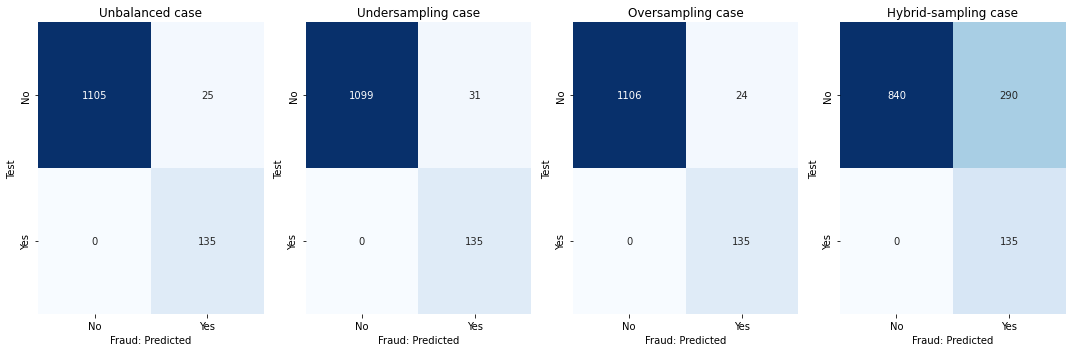

In [454]:
fig, ax = plt.subplots(1,4,figsize=(15,5))
labels=['No','Yes']

sns.heatmap(confusion_matrix(y_test, y_pred_1), annot=True, cmap="Blues", fmt='g', cbar=False,ax=ax[0])
ax[0].set_title('Unbalanced case')
ax[0].set_yticklabels(labels);
ax[0].set_xticklabels(labels);
ax[0].set_ylabel('Test')
ax[0].set_xlabel('Fraud: Predicted')

sns.heatmap(confusion_matrix(y_test, y_pred_2), annot=True, cmap="Blues", fmt='g', cbar=False,ax=ax[1])
ax[1].set_title('Undersampling case')
ax[1].set_yticklabels(labels);
ax[1].set_xticklabels(labels);
ax[1].set_ylabel('Test')
ax[1].set_xlabel('Fraud: Predicted')


sns.heatmap(confusion_matrix(y_test, y_pred_3), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[2])
ax[2].set_title('Oversampling case')
ax[2].set_xticklabels(labels);
ax[2].set_yticklabels(labels);
ax[2].set_ylabel('Test')
ax[2].set_xlabel('Fraud: Predicted')
plt.tight_layout()

sns.heatmap(confusion_matrix(y_test, y_pred_4), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[3])
ax[3].set_title('Hybrid-sampling case')
ax[3].set_xticklabels(labels);
ax[3].set_yticklabels(labels);
ax[3].set_ylabel('Test')
ax[3].set_xlabel('Fraud: Predicted')
plt.tight_layout()

plt.show()

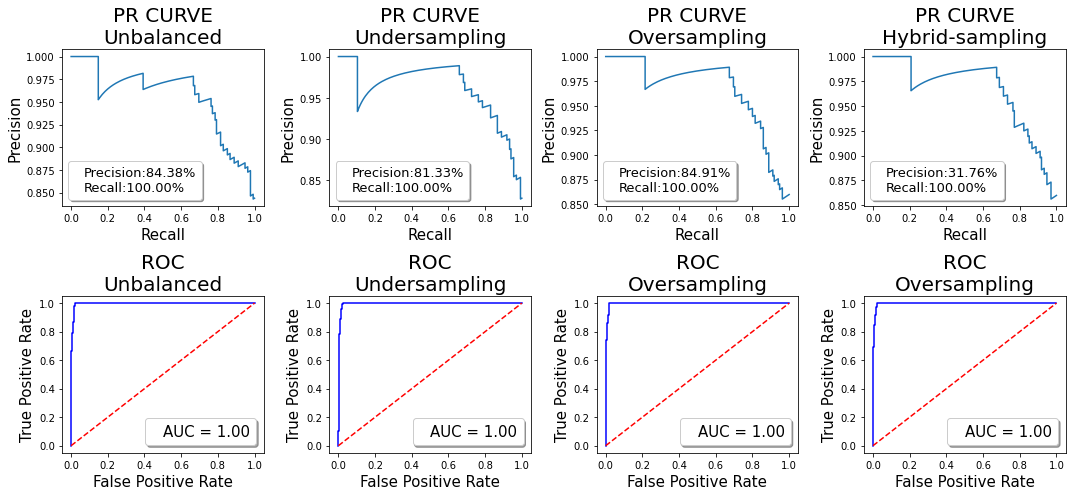

In [455]:
fig, ax = plt.subplots(2,4,figsize=(15,7))

####PR CURVES####

p,r,_ = precision_recall_curve(y_test,y_pred_prob_1)
ax[0,0].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_1)*100,recall_score(y_test, y_pred_1)*100))
ax[0,0].set_title('PR CURVE\nUnbalanced',fontsize=20)
ax[0,0].set_ylabel('Precision',fontsize=15)
ax[0,0].set_xlabel('Recall',fontsize=15)
ax[0,0].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

p,r,_ = precision_recall_curve(y_test,y_pred_prob_2)
ax[0,1].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_2)*100,recall_score(y_test, y_pred_2)*100))
ax[0,1].set_title('PR CURVE\nUndersampling',fontsize=20)
ax[0,1].set_ylabel('Precision',fontsize=15)
ax[0,1].set_xlabel('Recall',fontsize=15)
ax[0,1].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

p,r,_ = precision_recall_curve(y_test,y_pred_prob_3)
ax[0,2].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_3)*100,recall_score(y_test, y_pred_3)*100))
ax[0,2].set_title('PR CURVE\nOversampling',fontsize=20)
ax[0,2].set_ylabel('Precision',fontsize=15)
ax[0,2].set_xlabel('Recall',fontsize=15)
ax[0,2].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

p,r,_ = precision_recall_curve(y_test,y_pred_prob_4)
ax[0,3].plot(r,p, label = "Precision:{:.2f}%\nRecall:{:.2f}%".format(precision_score(y_test, y_pred_4)*100,recall_score(y_test, y_pred_4)*100))
ax[0,3].set_title('PR CURVE\nHybrid-sampling',fontsize=20)
ax[0,3].set_ylabel('Precision',fontsize=15)
ax[0,3].set_xlabel('Recall',fontsize=15)
ax[0,3].legend(loc = 'lower left', fontsize=13, fancybox=True, shadow=True, frameon=True,handlelength=0)

####ROC####


fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_1)
roc_auccat = auc(fprcat, tprcat)
ax[1,0].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,0].plot([0, 1], [0, 1],'r--')
ax[1,0].set_title('ROC\nUnbalanced',fontsize=20)
ax[1,0].set_ylabel('True Positive Rate',fontsize=15)
ax[1,0].set_xlabel('False Positive Rate',fontsize=15)
ax[1,0].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)

fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_2)
roc_auccat = auc(fprcat, tprcat)
ax[1,1].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,1].plot([0, 1], [0, 1],'r--')
ax[1,1].set_title('ROC\nUndersampling',fontsize=20)
ax[1,1].set_ylabel('True Positive Rate',fontsize=15)
ax[1,1].set_xlabel('False Positive Rate',fontsize=15)
ax[1,1].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)


fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_3)
roc_auccat = auc(fprcat, tprcat)
ax[1,2].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,2].plot([0, 1], [0, 1],'r--')
ax[1,2].set_title('ROC\nOversampling',fontsize=20)
ax[1,2].set_ylabel('True Positive Rate',fontsize=15)
ax[1,2].set_xlabel('False Positive Rate',fontsize=15)
ax[1,2].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)

fprcat, tprcat, _ = roc_curve(y_test, y_pred_prob_4)
roc_auccat = auc(fprcat, tprcat)
ax[1,3].plot(fprcat, tprcat, 'b', label = 'AUC = %0.2f' % roc_auccat)
ax[1,3].plot([0, 1], [0, 1],'r--')
ax[1,3].set_title('ROC\nOversampling',fontsize=20)
ax[1,3].set_ylabel('True Positive Rate',fontsize=15)
ax[1,3].set_xlabel('False Positive Rate',fontsize=15)
ax[1,3].legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)

plt.tight_layout()
plt.show()

# Social Network Analysis

In [456]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

shill.head(10)

,Record_ID,Auction_ID,Bidder_ID,Bidder_Tendency,Bidding_Ratio,Successive_Outbidding,Last_Bidding,Auction_Bids,Starting_Price_Average,Early_Bidding,Winning_Ratio,Auction_Duration,Class
0,1,732,_***i,0.200000,0.400000,0.0,0.000028,0.000000,0.993593,0.000028,0.666667,5,0
1,2,732,g***r,0.024390,0.200000,0.0,0.013123,0.000000,0.993593,0.013123,0.944444,5,0
2,3,732,t***p,0.142857,0.200000,0.0,0.003042,0.000000,0.993593,0.003042,1.000000,5,0
3,4,732,7***n,0.100000,0.200000,0.0,0.097477,0.000000,0.993593,0.097477,1.000000,5,0
4,5,900,z***z,0.051282,0.222222,0.0,0.001318,0.000000,0.000000,0.001242,0.500000,7,0
5,8,900,i***e,0.038462,0.111111,0.0,0.016844,0.000000,0.000000,0.016844,0.800000,7,0
6,10,900,m***p,0.400000,0.222222,0.0,0.006781,0.000000,0.000000,0.006774,0.750000,7,0
7,12,900,k***a,0.137931,0.444444,1.0,0.768044,0.000000,0.000000,0.016311,1.000000,7,1
8,13,2370,g***r,0.121951,0.185185,1.0,0.035021,0.333333,0.993528,0.023963,0.944444,7,1
9,27,600,e***t,0.155172,0.346154,0.5,0.570994,0.307692,0.993593,0.413788,0.611111,7,1


In [457]:
G = nx.from_pandas_edgelist(shill, 'Auction_ID', 'Bidder_ID')

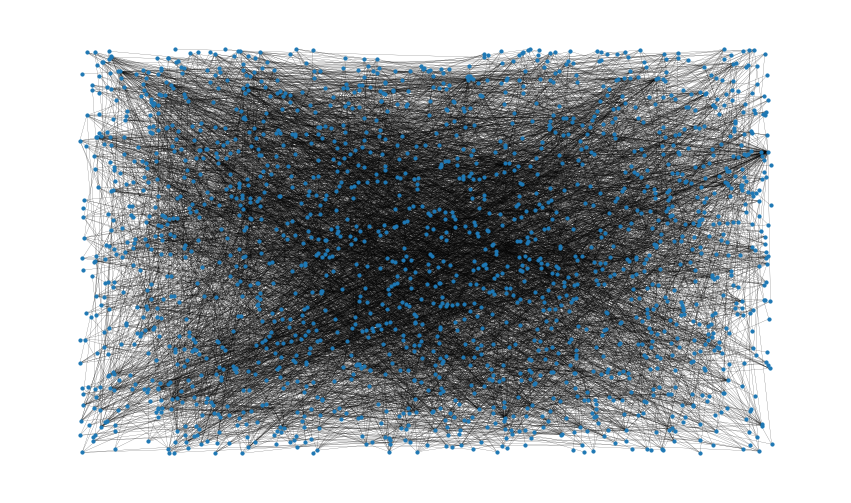

In [458]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis('off')
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

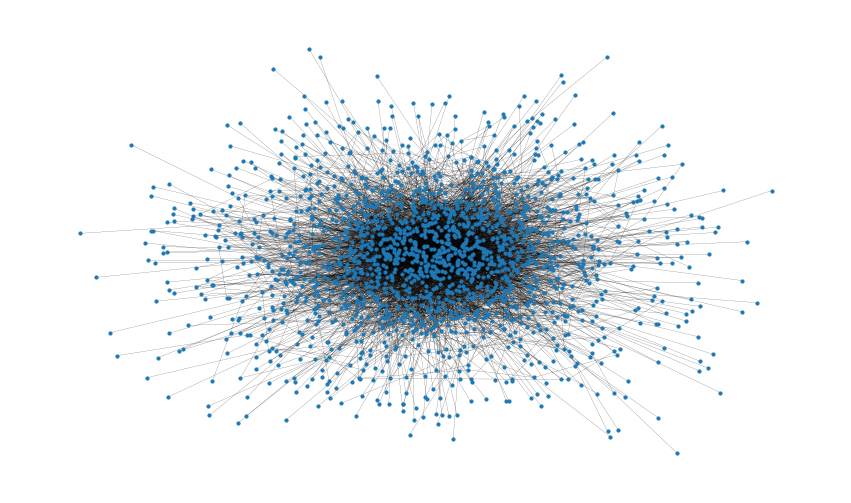

In [459]:
pos = nx.spring_layout(G, iterations=15, seed=42)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis('off')
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [460]:
G.number_of_nodes()

1861

In [461]:
G.number_of_edges()

6321

In [462]:
np.mean([d for _, d in G.degree()])


6.793121977431489

In [463]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

In [464]:
# This is equivalent to `diameter = nx.diameter(G), but much more efficient since we're
# reusing the pre-computed shortest path lengths!
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

8

In [465]:
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

4.131469188100092

Text(0, 0.5, 'Frequency (%)')

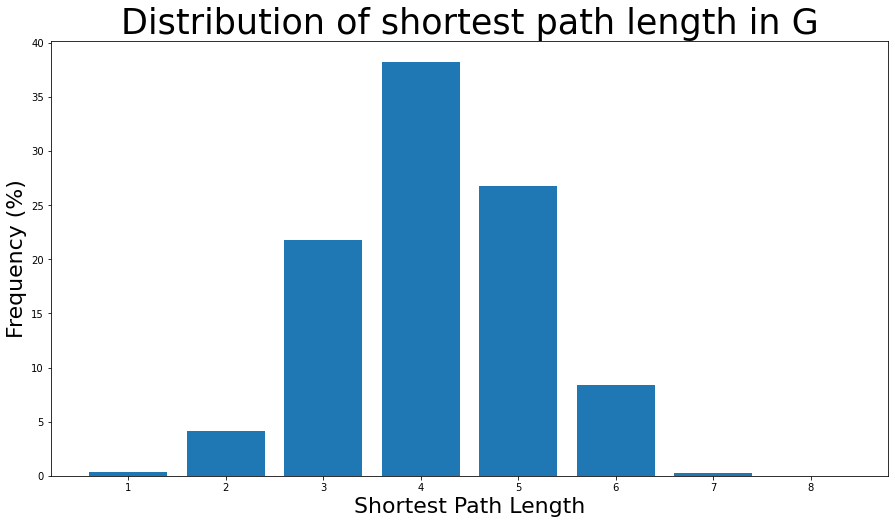

In [466]:
# We know the maximum shortest path length (the diameter), so create an array
# to store values from 0 up to (and including) diameter
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    'Distribution of shortest path length in G', fontdict ={'size': 35}, loc='center'
)
ax.set_xlabel('Shortest Path Length', fontdict ={'size': 22})
ax.set_ylabel('Frequency (%)', fontdict ={'size': 22})

In [467]:
nx.density(G)


0.00365221611689865

In [468]:
nx.number_connected_components(G)


1

In [469]:
degree_centrality = nx.centrality.degree_centrality(G)  # save results in a variable to use again 
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('a***a', 0.06021505376344086),
 ('n***t', 0.0456989247311828),
 ('e***e', 0.03602150537634408),
 ('i***a', 0.026881720430107527),
 ('r***r', 0.026344086021505377),
 ('l***l', 0.025806451612903226),
 ('o***o', 0.024193548387096774),
 ('i***i', 0.023655913978494623)]

In [470]:
# the number of neighbors for the nodes with the highest degree centralities:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:8]

[('a***a', 112),
 ('n***t', 85),
 ('e***e', 67),
 ('i***a', 50),
 ('r***r', 49),
 ('l***l', 48),
 ('o***o', 45),
 ('i***i', 44)]

Text(0, 0.5, 'Counts')

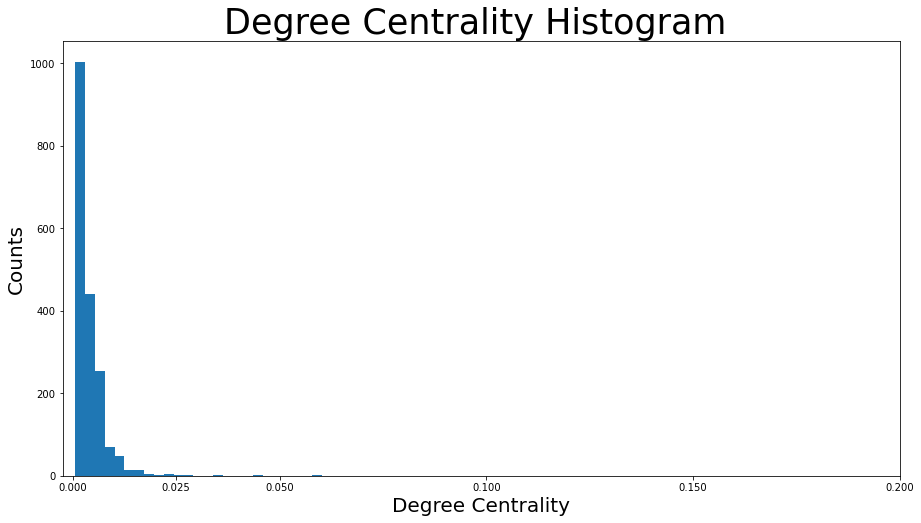

In [471]:
# the distribution of degree centralities will be plotted:

plt.figure(figsize=(15,8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title('Degree Centrality Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Degree Centrality', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

(-1.1842234084010124,
 1.1551079103350639,
 -1.1497679018974303,
 1.204276587963104)

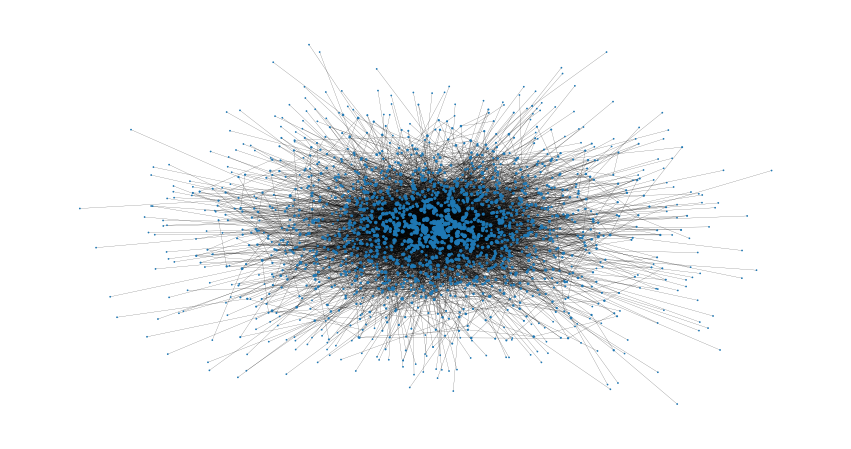

In [472]:
# check the users with highest degree centralities from the size of their nodes:

node_size =  [v * 1000 for v in degree_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')

In [473]:
betweenness_centrality = nx.centrality.betweenness_centrality(G)  # save results in a variable to use again 
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('a***a', 0.11825877867629687),
 ('n***t', 0.0792290220209026),
 ('e***e', 0.052208901399505035),
 ('r***r', 0.03180683341369728),
 ('l***l', 0.028540196293610848),
 ('i***a', 0.027253114653085574),
 ('r***h', 0.02595792854767867),
 ('i***i', 0.02592329829179095)]

Text(0, 0.5, 'Counts')

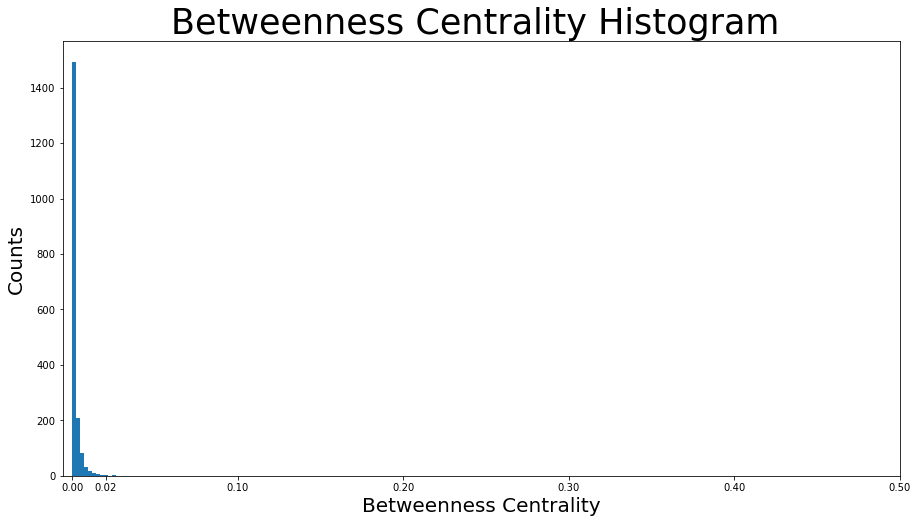

In [474]:
# the distribution of betweenness centralities will be plotted:

plt.figure(figsize=(15,8))
plt.hist(betweenness_centrality.values(), bins=50)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title('Betweenness Centrality Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Betweenness Centrality', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

(-1.1842234084010124,
 1.1551079103350639,
 -1.1497679018974303,
 1.204276587963104)

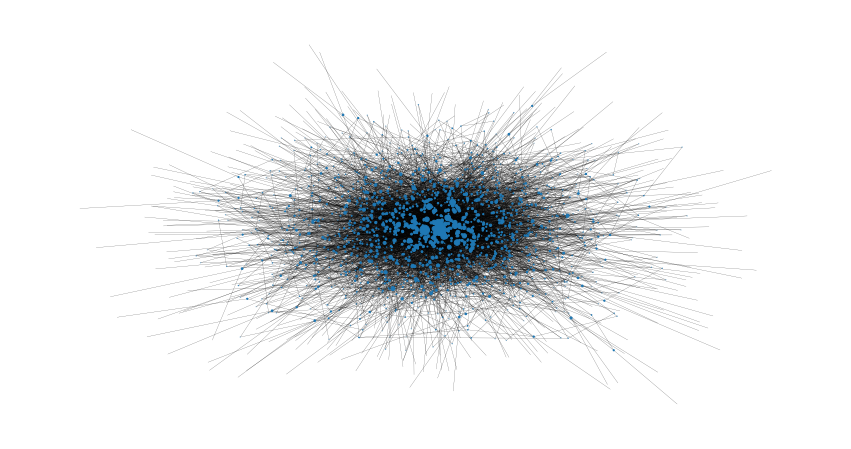

In [475]:
# We can also get an image on the nodes with the highest betweenness centralities and where they are located in the network. 
# It is clear that they are the bridges from one community to another:

node_size =  [v * 1200 for v in betweenness_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')

In [476]:
# The nodes with the highest closeness centralities will be found now:

closeness_centrality = nx.centrality.closeness_centrality(G)  # save results in a variable to use again 
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[('a***a', 0.34311012728278917),
 ('n***t', 0.33567948023822414),
 ('e***e', 0.321410057024365),
 ('r***h', 0.3135007584695769),
 (1872, 0.3134479271991911),
 ('r***r', 0.3107769423558897),
 ('i***i', 0.31015507753876936),
 ('o***o', 0.30953569645531703)]

Text(0, 0.5, 'Counts')

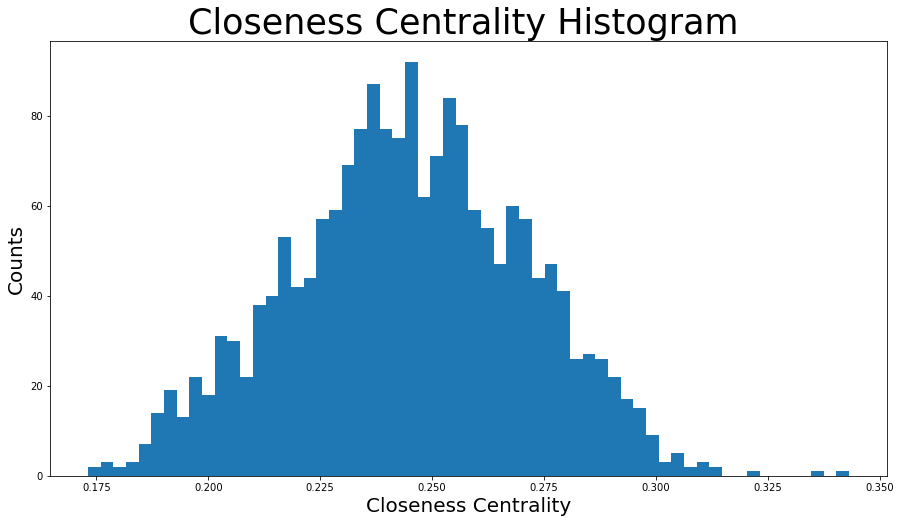

In [477]:
#the distribution of the closeness centralities:

plt.figure(figsize=(15,8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title('Closeness Centrality Histogram ', fontdict ={'size': 35}, loc='center') 
plt.xlabel('Closeness Centrality', fontdict ={'size': 20})
plt.ylabel('Counts',fontdict ={'size': 20})

(-1.1842234084010124,
 1.1551079103350639,
 -1.1497679018974303,
 1.204276587963104)

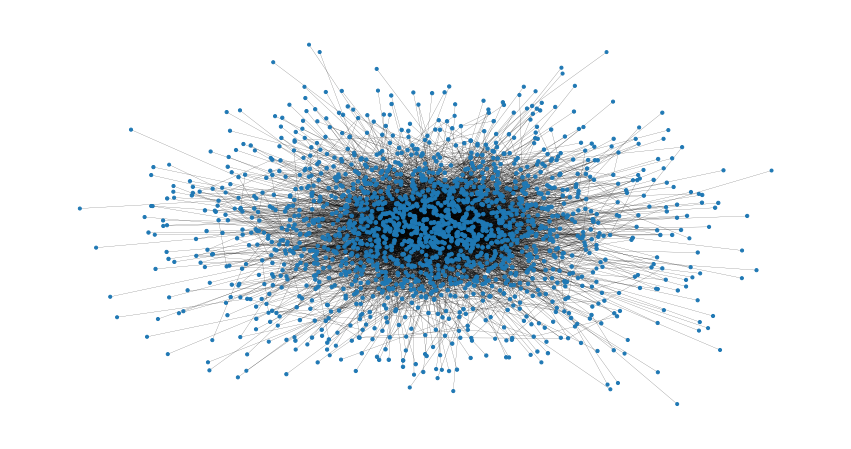

In [478]:
#there are some communities that are located further away, whose nodes would have the minimum closeness centralities, 
#as seen below:

node_size =  [v * 50 for v in closeness_centrality.values()]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15,8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis('off')